## 1. Camera Calibration
#### getting image points and object points

In [1]:
# Camera calibration 
# To find distortion co-efficients

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

calib_images = glob.glob('./camera_cal/calibration*.jpg')

#img = mpimg.imread('./camera_cal/calibration1.jpg')#ret -> False
#img = mpimg.imread('./camera_cal/calibration2.jpg')#ret -> False

#plt.imshow(img)
nx = 9
ny = 6
objpoints = []
imgpoints =[]
objpt = np.zeros((ny*nx,3),np.float32)
#print(objpt)

# Chess board corner co-ordinates in 3D
objpt[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
#print(objpt)

for f_name in calib_images:
    img = mpimg.imread(f_name)
    #Converting to gray for better corner detection
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #plt.imshow(gray,cmap = 'gray')

    # Finding Corners on chessboard
    ret,corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    #print(ret)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objpt)
        #displaying corners
        #img = cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
        #plt.imshow(img)


In [2]:
#print(len(objpoints))
#print(imgpoints)

In [3]:
# Camera Calibration
def Calibrate_camera(objpoints,imgpoints):
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

ret,mtx,dist,rvecs,tvecs = Calibrate_camera(objpoints,imgpoints)
print(mtx)


[[1.15396093e+03 0.00000000e+00 6.69705359e+02]
 [0.00000000e+00 1.14802495e+03 3.85656232e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


## 2. Reading an image and undistorting it

In [53]:
# Reading a road image with lane lines
rd_img = mpimg.imread('./test_images/test5.jpg')
print(rd_img.shape)
# Undistorting the test image
def undistort_img(rd_img):
    dst = cv2.undistort(rd_img,mtx,dist)
    #plt.imshow(dst)
    return dst


(720, 1280, 3)


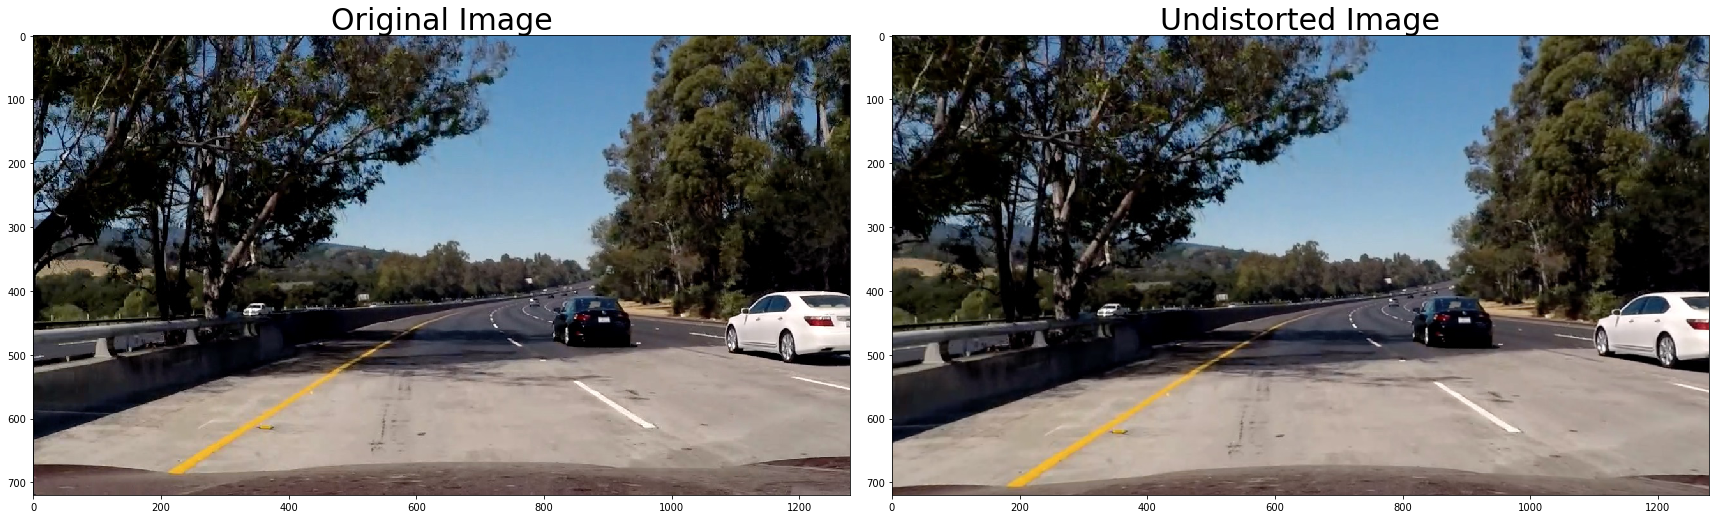

In [54]:
#Subplot Initialization to demo pipeline
f,(ax1,ax2) = plt.subplots(1,2,figsize = (24,9))
f.tight_layout()
#Plotting all the original and undstorted images on subplot
ax1.imshow(rd_img)
ax1.set_title('Original Image',fontsize=30)
undist_img = undistort_img(rd_img)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image',fontsize=30)

## 3. Color map ,Sobel edge detection and perspective transform

#### Color map thresholding

In [85]:
def sobel_with_color_chnl(rd_img):
    #Grayscale image of undistorted image
    undist_img = undistort_img(rd_img)
    rd_gray = cv2.cvtColor(undist_img,cv2.COLOR_RGB2GRAY)
    #plt.imshow(l_gray,cmap = 'gray')
    

    sobel_kernel = 3
    thres_min = 20
    thres_max = 180

    sobelx = cv2.Sobel(rd_gray,cv2.CV_64F,1,0)
    abs_sobelx = np.absolute(sobelx)

    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= thres_min) & (scaled_sobel <= thres_max)] = 1
    sobel_binary_output = np.copy(sybinary)
    #plt.imshow(sobel_binary_output,cmap='gray')
    #print(sobel_binary_output.shape)

    hls_img = cv2.cvtColor(undist_img,cv2.COLOR_RGB2HLS)
    # Choosing Saturation channel for gradient
    s_channel = hls_img[:,:,2]
    #plt.imshow(ls_img)
    l_channel = hls_img[:,:,1]
    #plt.imshow(ls_img,cmap = 'gray')
    #thres = (150,255)
    thres = (120,140)
    
    binary_s = np.zeros_like(s_channel)
    binary_s[(l_channel > thres[0]) & (s_channel > thres[1])] =1
    #plt.imshow(binary_s,cmap = 'gray')

    binary_image = sobel_binary_output | binary_s
    #plt.imshow(binary_image,cmap = 'gray')
    
    return binary_image

(720, 1280)


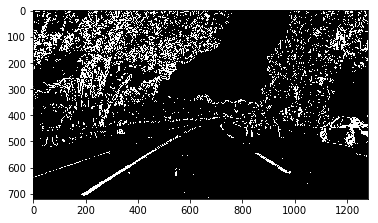

In [57]:
binary_image = sobel_with_color_chnl(rd_img)
plt.imshow(binary_image,cmap = 'gray')

##### defining region of interest
##### v1 = [0,720] v2 = [1280,720] apx = [700,400]

In [86]:
def roi_masked_img(binary_image):
    pv1 = np.array([[[100,720],[600,400],[800,400],[1200,720]]],dtype= np.int32)
    mask_img = np.zeros_like(binary_image)
    cv2.fillPoly(mask_img,pv1,1)

    binary_output = binary_image & mask_img
    return binary_output
    

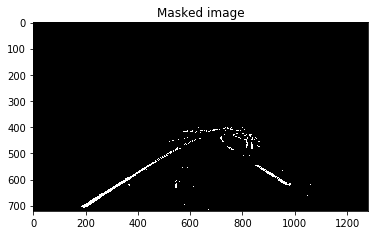

In [59]:
binary_output = roi_masked_img(binary_image)
plt.imshow(binary_output,cmap='gray')
plt.title('Masked image')

#### Perspective image for the masked image

In [87]:
def perspec_matrix(binary_output):
    src_pts = np.float32([[590,450],[695,450],[1090,680],[230,680]])
    dst_pts = np.float32([[300,0],[950,0],[950,719],[300,719]])
    #Compute the perspective transform M
    M = cv2.getPerspectiveTransform(src_pts,dst_pts)
    #Compute the inverse perspective transform Minv
    Minv = cv2.getPerspectiveTransform(dst_pts,src_pts)
    # Create warped image using linear interpolation
    return M,Minv
def warped_img(binary_output):
    img_size = (binary_output.shape[1],binary_output.shape[0])
    warped_img = cv2.warpPerspective(binary_output,M,img_size,flags = cv2.INTER_LINEAR)
    return warped_img


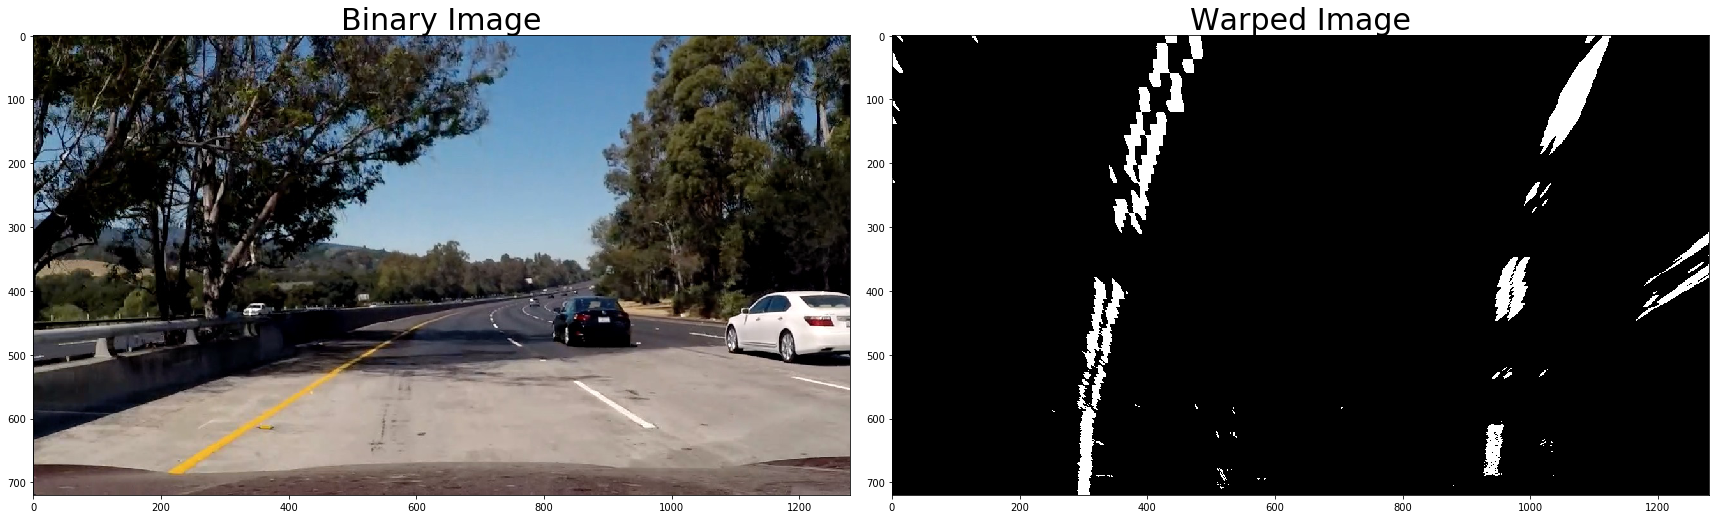

In [64]:
#Subplot Initialization for pileline demo
f,(ax1,ax2) = plt.subplots(1,2,figsize = (24,9))
f.tight_layout()
#Plotting all the original and undstorted images on subplot
ax1.imshow(rd_img,cmap='gray')
ax1.set_title('Binary Image',fontsize=30)

M,Minv = perspec_matrix(binary_output)

# warped_img = warped_img(rd_img)
warped_img = warped_img(binary_output)
ax2.imshow(warped_img,cmap='gray')
ax2.set_title('Warped Image',fontsize=30)

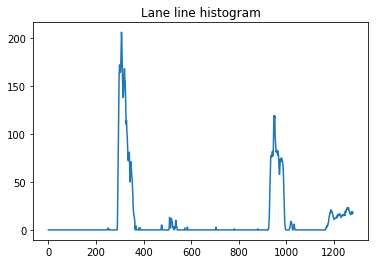

In [65]:
# Draw histogram of warped image
def plot_histogram(h_img):
    return np.sum(h_img[h_img.shape[0]//2:,:],axis = 0)

persp_img = np.copy(warped_img)
histogram = plot_histogram(persp_img)
plt.title('Lane line histogram')
plt.plot(histogram)

#### finding lane lines through sliding window 
###### In a perspective image

In [95]:
# to draw lane lines polynomial and filling the polynomial
class Lanefill():
    def __init__(self):
        self.lane_coeff =[]
    def draw_lane_polynomials(self,rd_img):

        bin_image = sobel_with_color_chnl(rd_img)
        roi_bin_image = roi_masked_img(bin_image)
        persp_img = warped_img(roi_bin_image)

        binary_warp = np.copy(persp_img)
        
        # Create a depth 3 output image to draw and visualize lane lines
        out_img = np.dstack((binary_warp,binary_warp,binary_warp))*255
        #plt.imshow(out_img)
        
        if len(self.lane_coeff) == 0:
            # taking a histogram of half of the image
            histogram = plot_histogram(binary_warp)
            # Finding left and right lane points on x-axis
            # these will be starting point of window
            midpoint = np.int(histogram.shape[0]//2)
            #print(midpoint)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[:midpoint]) + midpoint
            print(leftx_base,rightx_base)

            # Number of windows
            nwindows = 9
            window_height = np.int(binary_warp.shape[0]//nwindows)
            print(window_height)

            # Identify all non-zero pixels im warped image
            nonzero = binary_warp.nonzero()

            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # margin of width for window
            margin = 100
            # minimum number of pixel in window to recentre window
            minpix = 50

            #Empty list for left and right lane points
            left_lane_inds = []
            right_lane_inds = []

            #Iterating through windows
            for window in range(nwindows):#nwindows
                # window co-ords for left and right lane window
                win_y_low = binary_warp.shape[0] - (window+1)*window_height
                win_y_high = binary_warp.shape[0] - (window)*window_height
                win_xleft_low = leftx_base - margin
                win_xleft_high = leftx_base + margin
                win_xright_low = rightx_base - margin
                win_xright_high = rightx_base + margin
                #print(win_y_low,win_y_high)
                #print(win_xleft_low,win_xleft_high,win_xright_low,win_xright_high)

                # Identify non-zero pixels inside window from warped image
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)).nonzero()[0]

                # Append indices to list
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If we find #pixels > minpix we need to recentre window to the mean of window x'co-ords
                if len(good_left_inds) > minpix:
                    leftx_base = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:
                    rightx_base = np.int(np.mean(nonzerox[good_right_inds]))

            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right pixel co-ords
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]

            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
        else:
            # Skipping the windowing part
            
            
            
        # Fit a 2nd order polynomial for left and right lanes
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
        #print(left_fit,right_fit)
        
        # Adding line co efficients to global list for averaging or smoothening of line
        # Allowed #windows 10
        if len(self.lane_coeff) < 10:
            self.lane_coeff.append([left_fit.tolist(),right_fit.tolist()])
        else:
            self.lane_coeff = self.lane_coeff[1:]
            self.lane_coeff.append([left_fit.tolist(),right_fit.tolist()])
            
        ploty = np.linspace(0,binary_warp.shape[0]-1,binary_warp.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        blank_img = np.zeros_like(persp_img)
        blank_img_lane = np.dstack((blank_img,blank_img,blank_img))
        #print(blank_img_lane.shape)

        #plt.imshow(blank_img,cmap = 'gray')
    #     plt.plot(left_fitx,ploty,color = 'yellow')
    #     plt.plot(right_fitx,ploty,color = 'yellow')
    #     plt.xlim(0, 1280)
    #     plt.ylim(720, 0)

        # coloring window detected pixels
    #     out_img[nonzeroy[left_lane_inds],nonzerox[left_lane_inds]] = [255,0,0]
    #     out_img[nonzeroy[right_lane_inds],nonzerox[right_lane_inds]] = [0,0,255]

        # Fill color between lane lines
        left_lane_poly_pts = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
        right_lane_poly_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
        poly_points = np.hstack((left_lane_poly_pts,right_lane_poly_pts))

        cv2.fillPoly(blank_img_lane,np.int_([poly_points]),[0,255,0])

        # Inverse perspective transformation
        b_img_size = (blank_img_lane.shape[1],blank_img_lane.shape[0])
        unwarped_lane_area = cv2.warpPerspective(blank_img_lane,Minv,b_img_size,flags = cv2.INTER_LINEAR)

        img_lane_area_org = cv2.addWeighted(rd_img,1,unwarped_lane_area,0.2,0)
        #plt.imshow(img_lane_area_org)
        print(len(self.lane_coeff))
        return img_lane_area_org
    


(720, 1280)
307 947
80
(720, 1280, 3)


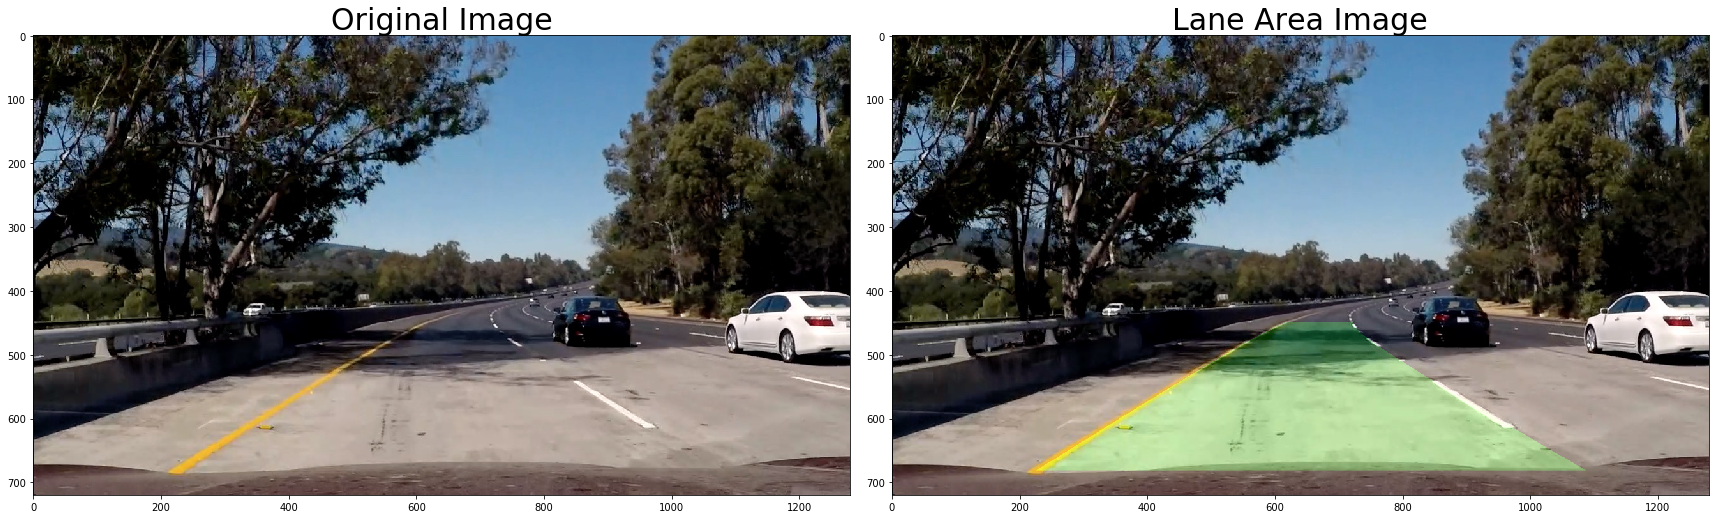

In [74]:
#Subplot Initialization for pileline demo
f,(ax1,ax2) = plt.subplots(1,2,figsize = (24,9))
f.tight_layout()
#Plotting all the original and undstorted images on subplot
ax1.imshow(rd_img,cmap='gray')
ax1.set_title('Original Image',fontsize=30)
img_lane_area = draw_lane_polynomials(rd_img)
ax2.imshow(img_lane_area,cmap='gray')
ax2.set_title('Lane Area Image',fontsize=30)

In [77]:
# Video processing code
from moviepy.editor import VideoFileClip
from IPython.display import HTML
pipe_obj = Lanefill()
video_output = './laneVideo.mp4'
clip1 = VideoFileClip("./project_video.mp4")
lane_clip = clip1.fl_image(pipe_obj.draw_lane_polynomials)
%time lane_clip.write_videofile(video_output,audio = False)

(720, 1280)
367 1007
80
(720, 1280, 3)
[MoviePy] >>>> Building video ./laneVideo.mp4
[MoviePy] Writing video ./laneVideo.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


  0%|                                                                                 | 1/1261 [00:00<09:18,  2.26it/s]

(720, 1280)
364 1004
80
(720, 1280, 3)


  0%|▏                                                                                | 2/1261 [00:00<08:15,  2.54it/s]

(720, 1280)
365 1005
80
(720, 1280, 3)


  0%|▏                                                                                | 3/1261 [00:01<08:04,  2.60it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


  0%|▎                                                                                | 4/1261 [00:01<08:11,  2.56it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


  0%|▎                                                                                | 5/1261 [00:01<08:25,  2.48it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


  0%|▍                                                                                | 6/1261 [00:02<08:08,  2.57it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


  1%|▍                                                                                | 7/1261 [00:02<08:18,  2.52it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


  1%|▌                                                                                | 8/1261 [00:03<08:04,  2.58it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


  1%|▌                                                                                | 9/1261 [00:03<07:38,  2.73it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


  1%|▋                                                                               | 10/1261 [00:03<08:01,  2.60it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


  1%|▋                                                                               | 11/1261 [00:04<08:06,  2.57it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


  1%|▊                                                                               | 12/1261 [00:04<08:05,  2.57it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


  1%|▊                                                                               | 13/1261 [00:05<08:43,  2.39it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


  1%|▉                                                                               | 14/1261 [00:05<08:02,  2.58it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


  1%|▉                                                                               | 15/1261 [00:05<06:49,  3.04it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


  1%|█                                                                               | 16/1261 [00:05<06:25,  3.23it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


  1%|█                                                                               | 17/1261 [00:06<05:33,  3.73it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


  1%|█▏                                                                              | 18/1261 [00:06<04:57,  4.18it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


  2%|█▏                                                                              | 19/1261 [00:06<04:37,  4.47it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


  2%|█▎                                                                              | 20/1261 [00:06<05:36,  3.69it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


  2%|█▎                                                                              | 21/1261 [00:07<06:19,  3.27it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


  2%|█▍                                                                              | 22/1261 [00:07<06:05,  3.39it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


  2%|█▍                                                                              | 23/1261 [00:07<06:19,  3.26it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


  2%|█▌                                                                              | 24/1261 [00:08<06:14,  3.30it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


  2%|█▌                                                                              | 25/1261 [00:08<06:16,  3.29it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


  2%|█▋                                                                              | 26/1261 [00:08<06:28,  3.18it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


  2%|█▋                                                                              | 27/1261 [00:08<06:11,  3.32it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


  2%|█▊                                                                              | 28/1261 [00:09<06:17,  3.27it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


  2%|█▊                                                                              | 29/1261 [00:09<05:57,  3.45it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


  2%|█▉                                                                              | 30/1261 [00:09<05:17,  3.88it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


  2%|█▉                                                                              | 31/1261 [00:09<04:57,  4.13it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


  3%|██                                                                              | 32/1261 [00:10<05:09,  3.98it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


  3%|██                                                                              | 33/1261 [00:10<05:12,  3.93it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


  3%|██▏                                                                             | 34/1261 [00:10<05:12,  3.93it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


  3%|██▏                                                                             | 35/1261 [00:10<05:05,  4.01it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


  3%|██▎                                                                             | 36/1261 [00:11<05:11,  3.94it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


  3%|██▎                                                                             | 37/1261 [00:11<05:15,  3.87it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


  3%|██▍                                                                             | 38/1261 [00:11<05:13,  3.90it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


  3%|██▍                                                                             | 39/1261 [00:11<05:11,  3.92it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


  3%|██▌                                                                             | 40/1261 [00:12<05:04,  4.01it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


  3%|██▌                                                                             | 41/1261 [00:12<04:46,  4.25it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


  3%|██▋                                                                             | 42/1261 [00:12<04:31,  4.49it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


  3%|██▋                                                                             | 43/1261 [00:12<04:44,  4.29it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


  3%|██▊                                                                             | 44/1261 [00:13<04:38,  4.37it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


  4%|██▊                                                                             | 45/1261 [00:13<04:34,  4.43it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


  4%|██▉                                                                             | 46/1261 [00:13<04:21,  4.65it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


  4%|██▉                                                                             | 47/1261 [00:13<04:07,  4.91it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


  4%|███                                                                             | 48/1261 [00:13<04:07,  4.90it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


  4%|███                                                                             | 49/1261 [00:14<04:07,  4.90it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


  4%|███▏                                                                            | 50/1261 [00:14<04:24,  4.59it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


  4%|███▏                                                                            | 51/1261 [00:14<04:15,  4.73it/s]

(720, 1280)
364 1004
80
(720, 1280, 3)


  4%|███▎                                                                            | 52/1261 [00:14<05:08,  3.92it/s]

(720, 1280)
364 1004
80
(720, 1280, 3)


  4%|███▎                                                                            | 53/1261 [00:15<04:57,  4.06it/s]

(720, 1280)
364 1004
80
(720, 1280, 3)


  4%|███▍                                                                            | 54/1261 [00:15<05:06,  3.93it/s]

(720, 1280)
364 1004
80
(720, 1280, 3)


  4%|███▍                                                                            | 55/1261 [00:15<05:38,  3.56it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


  4%|███▌                                                                            | 56/1261 [00:15<05:12,  3.85it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


  5%|███▌                                                                            | 57/1261 [00:16<05:42,  3.51it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


  5%|███▋                                                                            | 58/1261 [00:16<05:28,  3.66it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


  5%|███▋                                                                            | 59/1261 [00:16<05:25,  3.70it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


  5%|███▊                                                                            | 60/1261 [00:17<05:58,  3.35it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


  5%|███▊                                                                            | 61/1261 [00:17<05:43,  3.50it/s]

(720, 1280)
351 991
80
(720, 1280, 3)


  5%|███▉                                                                            | 62/1261 [00:17<05:23,  3.71it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


  5%|███▉                                                                            | 63/1261 [00:17<05:50,  3.42it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


  5%|████                                                                            | 64/1261 [00:18<05:30,  3.62it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


  5%|████                                                                            | 65/1261 [00:18<05:38,  3.53it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


  5%|████▏                                                                           | 66/1261 [00:18<05:19,  3.74it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


  5%|████▎                                                                           | 67/1261 [00:18<04:51,  4.09it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


  5%|████▎                                                                           | 68/1261 [00:19<04:37,  4.29it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


  5%|████▍                                                                           | 69/1261 [00:19<04:43,  4.21it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


  6%|████▍                                                                           | 70/1261 [00:19<04:26,  4.46it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


  6%|████▌                                                                           | 71/1261 [00:19<04:28,  4.43it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


  6%|████▌                                                                           | 72/1261 [00:20<04:22,  4.52it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


  6%|████▋                                                                           | 73/1261 [00:20<04:25,  4.47it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


  6%|████▋                                                                           | 74/1261 [00:20<04:20,  4.56it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


  6%|████▊                                                                           | 75/1261 [00:20<04:13,  4.67it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


  6%|████▊                                                                           | 76/1261 [00:20<04:14,  4.66it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


  6%|████▉                                                                           | 77/1261 [00:21<04:32,  4.34it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


  6%|████▉                                                                           | 78/1261 [00:21<04:37,  4.27it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


  6%|█████                                                                           | 79/1261 [00:21<04:47,  4.11it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


  6%|█████                                                                           | 80/1261 [00:21<05:09,  3.82it/s]

(720, 1280)
332 972
80
(720, 1280, 3)


  6%|█████▏                                                                          | 81/1261 [00:22<05:48,  3.39it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


  7%|█████▏                                                                          | 82/1261 [00:22<05:39,  3.47it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


  7%|█████▎                                                                          | 83/1261 [00:22<05:47,  3.39it/s]

(720, 1280)
316 956
80
(720, 1280, 3)


  7%|█████▎                                                                          | 84/1261 [00:23<05:47,  3.38it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


  7%|█████▍                                                                          | 85/1261 [00:23<05:58,  3.28it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


  7%|█████▍                                                                          | 86/1261 [00:23<06:21,  3.08it/s]

(720, 1280)
333 973
80
(720, 1280, 3)


  7%|█████▌                                                                          | 87/1261 [00:24<07:10,  2.73it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


  7%|█████▌                                                                          | 88/1261 [00:24<07:25,  2.64it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


  7%|█████▋                                                                          | 89/1261 [00:25<07:34,  2.58it/s]

(720, 1280)
337 977
80
(720, 1280, 3)


  7%|█████▋                                                                          | 90/1261 [00:25<08:17,  2.35it/s]

(720, 1280)
336 976
80
(720, 1280, 3)


  7%|█████▊                                                                          | 91/1261 [00:26<08:25,  2.31it/s]

(720, 1280)
337 977
80
(720, 1280, 3)


  7%|█████▊                                                                          | 92/1261 [00:26<08:22,  2.33it/s]

(720, 1280)
339 979
80
(720, 1280, 3)


  7%|█████▉                                                                          | 93/1261 [00:27<08:19,  2.34it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


  7%|█████▉                                                                          | 94/1261 [00:27<07:21,  2.64it/s]

(720, 1280)
339 979
80
(720, 1280, 3)


  8%|██████                                                                          | 95/1261 [00:27<07:27,  2.61it/s]

(720, 1280)
339 979
80
(720, 1280, 3)


  8%|██████                                                                          | 96/1261 [00:27<06:58,  2.78it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


  8%|██████▏                                                                         | 97/1261 [00:28<06:06,  3.17it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


  8%|██████▏                                                                         | 98/1261 [00:28<06:38,  2.92it/s]

(720, 1280)
341 981
80
(720, 1280, 3)


  8%|██████▎                                                                         | 99/1261 [00:28<06:36,  2.93it/s]

(720, 1280)
341 981
80
(720, 1280, 3)


  8%|██████▎                                                                        | 100/1261 [00:29<05:56,  3.25it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


  8%|██████▎                                                                        | 101/1261 [00:29<05:37,  3.44it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


  8%|██████▍                                                                        | 102/1261 [00:29<05:09,  3.75it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


  8%|██████▍                                                                        | 103/1261 [00:29<05:03,  3.82it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


  8%|██████▌                                                                        | 104/1261 [00:30<04:49,  4.00it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


  8%|██████▌                                                                        | 105/1261 [00:30<04:54,  3.92it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


  8%|██████▋                                                                        | 106/1261 [00:30<04:41,  4.10it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


  8%|██████▋                                                                        | 107/1261 [00:30<04:30,  4.27it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


  9%|██████▊                                                                        | 108/1261 [00:31<04:26,  4.33it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


  9%|██████▊                                                                        | 109/1261 [00:31<04:38,  4.13it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


  9%|██████▉                                                                        | 110/1261 [00:31<05:16,  3.64it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


  9%|██████▉                                                                        | 111/1261 [00:31<05:22,  3.57it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


  9%|███████                                                                        | 112/1261 [00:32<05:19,  3.59it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


  9%|███████                                                                        | 113/1261 [00:32<05:35,  3.42it/s]

(720, 1280)
351 991
80
(720, 1280, 3)


  9%|███████▏                                                                       | 114/1261 [00:32<05:12,  3.67it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


  9%|███████▏                                                                       | 115/1261 [00:32<04:59,  3.83it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


  9%|███████▎                                                                       | 116/1261 [00:33<04:47,  3.99it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


  9%|███████▎                                                                       | 117/1261 [00:33<04:54,  3.88it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


  9%|███████▍                                                                       | 118/1261 [00:33<04:51,  3.92it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


  9%|███████▍                                                                       | 119/1261 [00:34<05:01,  3.79it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 10%|███████▌                                                                       | 120/1261 [00:34<04:53,  3.89it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 10%|███████▌                                                                       | 121/1261 [00:34<04:49,  3.94it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 10%|███████▋                                                                       | 122/1261 [00:34<05:26,  3.49it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 10%|███████▋                                                                       | 123/1261 [00:35<05:50,  3.25it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 10%|███████▊                                                                       | 124/1261 [00:35<05:22,  3.52it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 10%|███████▊                                                                       | 125/1261 [00:35<06:41,  2.83it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 10%|███████▉                                                                       | 126/1261 [00:36<06:08,  3.08it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 10%|███████▉                                                                       | 127/1261 [00:36<06:13,  3.04it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 10%|████████                                                                       | 128/1261 [00:36<06:35,  2.86it/s]

(720, 1280)
365 1005
80
(720, 1280, 3)


 10%|████████                                                                       | 129/1261 [00:37<06:49,  2.77it/s]

(720, 1280)
365 1005
80
(720, 1280, 3)


 10%|████████▏                                                                      | 130/1261 [00:37<06:33,  2.88it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 10%|████████▏                                                                      | 131/1261 [00:38<07:04,  2.66it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 10%|████████▎                                                                      | 132/1261 [00:38<06:32,  2.88it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 11%|████████▎                                                                      | 133/1261 [00:38<06:05,  3.08it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 11%|████████▍                                                                      | 134/1261 [00:39<06:27,  2.91it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


 11%|████████▍                                                                      | 135/1261 [00:39<06:00,  3.13it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 11%|████████▌                                                                      | 136/1261 [00:39<05:31,  3.39it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 11%|████████▌                                                                      | 137/1261 [00:39<05:18,  3.53it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 11%|████████▋                                                                      | 138/1261 [00:40<05:09,  3.63it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 11%|████████▋                                                                      | 139/1261 [00:40<05:39,  3.31it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 11%|████████▊                                                                      | 140/1261 [00:40<05:39,  3.30it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 11%|████████▊                                                                      | 141/1261 [00:41<05:32,  3.37it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 11%|████████▉                                                                      | 142/1261 [00:41<05:17,  3.53it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 11%|████████▉                                                                      | 143/1261 [00:41<05:05,  3.66it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 11%|█████████                                                                      | 144/1261 [00:41<05:17,  3.52it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 11%|█████████                                                                      | 145/1261 [00:42<04:53,  3.80it/s]

(720, 1280)
365 1005
80
(720, 1280, 3)


 12%|█████████▏                                                                     | 146/1261 [00:42<04:52,  3.82it/s]

(720, 1280)
365 1005
80
(720, 1280, 3)


 12%|█████████▏                                                                     | 147/1261 [00:42<04:45,  3.90it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 12%|█████████▎                                                                     | 148/1261 [00:42<04:38,  3.99it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 12%|█████████▎                                                                     | 149/1261 [00:43<04:40,  3.97it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 12%|█████████▍                                                                     | 150/1261 [00:43<04:31,  4.09it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 12%|█████████▍                                                                     | 151/1261 [00:43<04:45,  3.89it/s]

(720, 1280)
364 1004
80
(720, 1280, 3)


 12%|█████████▌                                                                     | 152/1261 [00:43<04:50,  3.82it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 12%|█████████▌                                                                     | 153/1261 [00:44<04:52,  3.79it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 12%|█████████▋                                                                     | 154/1261 [00:44<05:00,  3.69it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 12%|█████████▋                                                                     | 155/1261 [00:44<05:12,  3.53it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 12%|█████████▊                                                                     | 156/1261 [00:44<05:17,  3.48it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 12%|█████████▊                                                                     | 157/1261 [00:45<05:59,  3.07it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 13%|█████████▉                                                                     | 158/1261 [00:45<05:31,  3.33it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


 13%|█████████▉                                                                     | 159/1261 [00:45<05:43,  3.21it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 13%|██████████                                                                     | 160/1261 [00:46<06:10,  2.97it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 13%|██████████                                                                     | 161/1261 [00:46<05:50,  3.14it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 13%|██████████▏                                                                    | 162/1261 [00:46<05:48,  3.16it/s]

(720, 1280)
351 991
80
(720, 1280, 3)


 13%|██████████▏                                                                    | 163/1261 [00:47<06:26,  2.84it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 13%|██████████▎                                                                    | 164/1261 [00:47<05:47,  3.16it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 13%|██████████▎                                                                    | 165/1261 [00:47<05:52,  3.11it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 13%|██████████▍                                                                    | 166/1261 [00:48<05:56,  3.07it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 13%|██████████▍                                                                    | 167/1261 [00:48<06:00,  3.04it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 13%|██████████▌                                                                    | 168/1261 [00:48<05:25,  3.36it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 13%|██████████▌                                                                    | 169/1261 [00:49<05:25,  3.36it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


 13%|██████████▋                                                                    | 170/1261 [00:49<05:17,  3.44it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


 14%|██████████▋                                                                    | 171/1261 [00:49<05:00,  3.63it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 14%|██████████▊                                                                    | 172/1261 [00:49<04:54,  3.70it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 14%|██████████▊                                                                    | 173/1261 [00:50<04:47,  3.78it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 14%|██████████▉                                                                    | 174/1261 [00:50<04:51,  3.73it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 14%|██████████▉                                                                    | 175/1261 [00:50<04:36,  3.93it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 14%|███████████                                                                    | 176/1261 [00:50<04:45,  3.80it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 14%|███████████                                                                    | 177/1261 [00:51<04:41,  3.85it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 14%|███████████▏                                                                   | 178/1261 [00:51<04:45,  3.79it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 14%|███████████▏                                                                   | 179/1261 [00:51<04:39,  3.87it/s]

(720, 1280)
337 977
80
(720, 1280, 3)


 14%|███████████▎                                                                   | 180/1261 [00:52<05:07,  3.52it/s]

(720, 1280)
342 982
80
(720, 1280, 3)


 14%|███████████▎                                                                   | 181/1261 [00:52<04:49,  3.73it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 14%|███████████▍                                                                   | 182/1261 [00:52<04:43,  3.80it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 15%|███████████▍                                                                   | 183/1261 [00:52<04:41,  3.83it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 15%|███████████▌                                                                   | 184/1261 [00:53<04:41,  3.83it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 15%|███████████▌                                                                   | 185/1261 [00:53<04:39,  3.85it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 15%|███████████▋                                                                   | 186/1261 [00:53<05:26,  3.29it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 15%|███████████▋                                                                   | 187/1261 [00:54<06:09,  2.90it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 15%|███████████▊                                                                   | 188/1261 [00:54<06:00,  2.98it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 15%|███████████▊                                                                   | 189/1261 [00:54<06:15,  2.86it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 15%|███████████▉                                                                   | 190/1261 [00:55<06:24,  2.79it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 15%|███████████▉                                                                   | 191/1261 [00:55<05:48,  3.07it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 15%|████████████                                                                   | 192/1261 [00:55<05:52,  3.03it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


 15%|████████████                                                                   | 193/1261 [00:56<06:11,  2.88it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 15%|████████████▏                                                                  | 194/1261 [00:56<06:03,  2.93it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 15%|████████████▏                                                                  | 195/1261 [00:56<05:52,  3.02it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


 16%|████████████▎                                                                  | 196/1261 [00:57<06:12,  2.86it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 16%|████████████▎                                                                  | 197/1261 [00:57<05:40,  3.12it/s]

(720, 1280)
351 991
80
(720, 1280, 3)


 16%|████████████▍                                                                  | 198/1261 [00:57<06:02,  2.93it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 16%|████████████▍                                                                  | 199/1261 [00:58<06:17,  2.82it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 16%|████████████▌                                                                  | 200/1261 [00:58<05:57,  2.97it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 16%|████████████▌                                                                  | 201/1261 [00:58<05:33,  3.18it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 16%|████████████▋                                                                  | 202/1261 [00:59<05:23,  3.28it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 16%|████████████▋                                                                  | 203/1261 [00:59<05:12,  3.39it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 16%|████████████▊                                                                  | 204/1261 [00:59<04:59,  3.53it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 16%|████████████▊                                                                  | 205/1261 [00:59<04:39,  3.78it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 16%|████████████▉                                                                  | 206/1261 [01:00<04:55,  3.57it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 16%|████████████▉                                                                  | 207/1261 [01:00<04:48,  3.65it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 16%|█████████████                                                                  | 208/1261 [01:00<04:42,  3.73it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 17%|█████████████                                                                  | 209/1261 [01:00<04:23,  3.99it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 17%|█████████████▏                                                                 | 210/1261 [01:01<04:37,  3.79it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 17%|█████████████▏                                                                 | 211/1261 [01:01<04:29,  3.89it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 17%|█████████████▎                                                                 | 212/1261 [01:01<04:44,  3.68it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 17%|█████████████▎                                                                 | 213/1261 [01:02<04:33,  3.83it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 17%|█████████████▍                                                                 | 214/1261 [01:02<04:37,  3.78it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 17%|█████████████▍                                                                 | 215/1261 [01:02<04:32,  3.84it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 17%|█████████████▌                                                                 | 216/1261 [01:02<04:46,  3.65it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 17%|█████████████▌                                                                 | 217/1261 [01:03<04:37,  3.76it/s]

(720, 1280)
341 981
80
(720, 1280, 3)


 17%|█████████████▋                                                                 | 218/1261 [01:03<04:46,  3.64it/s]

(720, 1280)
341 981
80
(720, 1280, 3)


 17%|█████████████▋                                                                 | 219/1261 [01:03<04:31,  3.84it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 17%|█████████████▊                                                                 | 220/1261 [01:03<04:33,  3.81it/s]

(720, 1280)
341 981
80
(720, 1280, 3)


 18%|█████████████▊                                                                 | 221/1261 [01:04<05:05,  3.40it/s]

(720, 1280)
342 982
80
(720, 1280, 3)


 18%|█████████████▉                                                                 | 222/1261 [01:04<05:55,  2.92it/s]

(720, 1280)
342 982
80
(720, 1280, 3)


 18%|█████████████▉                                                                 | 223/1261 [01:04<05:29,  3.15it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 18%|██████████████                                                                 | 224/1261 [01:05<05:40,  3.05it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 18%|██████████████                                                                 | 225/1261 [01:05<05:46,  2.99it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 18%|██████████████▏                                                                | 226/1261 [01:06<06:14,  2.76it/s]

(720, 1280)
342 982
80
(720, 1280, 3)


 18%|██████████████▏                                                                | 227/1261 [01:06<05:48,  2.97it/s]

(720, 1280)
341 981
80
(720, 1280, 3)


 18%|██████████████▎                                                                | 228/1261 [01:06<05:57,  2.89it/s]

(720, 1280)
339 979
80
(720, 1280, 3)


 18%|██████████████▎                                                                | 229/1261 [01:07<06:08,  2.80it/s]

(720, 1280)
338 978
80
(720, 1280, 3)


 18%|██████████████▍                                                                | 230/1261 [01:07<06:16,  2.74it/s]

(720, 1280)
337 977
80
(720, 1280, 3)


 18%|██████████████▍                                                                | 231/1261 [01:07<05:36,  3.06it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


 18%|██████████████▌                                                                | 232/1261 [01:08<06:04,  2.82it/s]

(720, 1280)
333 973
80
(720, 1280, 3)


 18%|██████████████▌                                                                | 233/1261 [01:08<05:54,  2.90it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 19%|██████████████▋                                                                | 234/1261 [01:08<05:27,  3.14it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 19%|██████████████▋                                                                | 235/1261 [01:09<05:44,  2.98it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 19%|██████████████▊                                                                | 236/1261 [01:09<05:14,  3.26it/s]

(720, 1280)
327 967
80
(720, 1280, 3)


 19%|██████████████▊                                                                | 237/1261 [01:09<04:47,  3.56it/s]

(720, 1280)
326 966
80
(720, 1280, 3)


 19%|██████████████▉                                                                | 238/1261 [01:09<04:53,  3.48it/s]

(720, 1280)
327 967
80
(720, 1280, 3)


 19%|██████████████▉                                                                | 239/1261 [01:10<04:44,  3.59it/s]

(720, 1280)
326 966
80
(720, 1280, 3)


 19%|███████████████                                                                | 240/1261 [01:10<05:22,  3.17it/s]

(720, 1280)
327 967
80
(720, 1280, 3)


 19%|███████████████                                                                | 241/1261 [01:10<04:52,  3.49it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 19%|███████████████▏                                                               | 242/1261 [01:11<05:00,  3.39it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 19%|███████████████▏                                                               | 243/1261 [01:11<04:48,  3.53it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 19%|███████████████▎                                                               | 244/1261 [01:11<04:52,  3.47it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 19%|███████████████▎                                                               | 245/1261 [01:11<04:38,  3.65it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 20%|███████████████▍                                                               | 246/1261 [01:12<04:32,  3.73it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 20%|███████████████▍                                                               | 247/1261 [01:12<04:23,  3.84it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 20%|███████████████▌                                                               | 248/1261 [01:12<04:17,  3.93it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 20%|███████████████▌                                                               | 249/1261 [01:13<05:02,  3.35it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 20%|███████████████▋                                                               | 250/1261 [01:13<04:59,  3.38it/s]

(720, 1280)
319 959
80
(720, 1280, 3)


 20%|███████████████▋                                                               | 251/1261 [01:13<04:37,  3.64it/s]

(720, 1280)
319 959
80
(720, 1280, 3)


 20%|███████████████▊                                                               | 252/1261 [01:13<05:24,  3.11it/s]

(720, 1280)
319 959
80
(720, 1280, 3)


 20%|███████████████▊                                                               | 253/1261 [01:14<05:45,  2.92it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 20%|███████████████▉                                                               | 254/1261 [01:14<06:14,  2.69it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 20%|███████████████▉                                                               | 255/1261 [01:15<05:40,  2.96it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 20%|████████████████                                                               | 256/1261 [01:15<06:07,  2.73it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 20%|████████████████                                                               | 257/1261 [01:15<06:10,  2.71it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 20%|████████████████▏                                                              | 258/1261 [01:16<05:37,  2.98it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 21%|████████████████▏                                                              | 259/1261 [01:16<06:21,  2.63it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 21%|████████████████▎                                                              | 260/1261 [01:16<06:24,  2.61it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 21%|████████████████▎                                                              | 261/1261 [01:17<06:24,  2.60it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 21%|████████████████▍                                                              | 262/1261 [01:17<06:10,  2.69it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 21%|████████████████▍                                                              | 263/1261 [01:18<06:12,  2.68it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 21%|████████████████▌                                                              | 264/1261 [01:18<05:48,  2.86it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 21%|████████████████▌                                                              | 265/1261 [01:18<05:00,  3.32it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 21%|████████████████▋                                                              | 266/1261 [01:19<06:58,  2.38it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 21%|████████████████▋                                                              | 267/1261 [01:19<06:08,  2.70it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 21%|████████████████▊                                                              | 268/1261 [01:19<06:08,  2.70it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 21%|████████████████▊                                                              | 269/1261 [01:20<05:31,  2.99it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 21%|████████████████▉                                                              | 270/1261 [01:20<05:02,  3.27it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 21%|████████████████▉                                                              | 271/1261 [01:20<05:13,  3.16it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 22%|█████████████████                                                              | 272/1261 [01:20<04:43,  3.49it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 22%|█████████████████                                                              | 273/1261 [01:21<04:30,  3.65it/s]

(720, 1280)
328 968
80
(720, 1280, 3)


 22%|█████████████████▏                                                             | 274/1261 [01:21<04:54,  3.35it/s]

(720, 1280)
328 968
80
(720, 1280, 3)


 22%|█████████████████▏                                                             | 275/1261 [01:21<04:54,  3.35it/s]

(720, 1280)
328 968
80
(720, 1280, 3)


 22%|█████████████████▎                                                             | 276/1261 [01:22<04:38,  3.54it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 22%|█████████████████▎                                                             | 277/1261 [01:22<04:27,  3.68it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 22%|█████████████████▍                                                             | 278/1261 [01:22<04:36,  3.55it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 22%|█████████████████▍                                                             | 279/1261 [01:22<04:30,  3.63it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 22%|█████████████████▌                                                             | 280/1261 [01:23<04:21,  3.74it/s]

(720, 1280)
332 972
80
(720, 1280, 3)


 22%|█████████████████▌                                                             | 281/1261 [01:23<05:27,  2.99it/s]

(720, 1280)
334 974
80
(720, 1280, 3)


 22%|█████████████████▋                                                             | 282/1261 [01:24<05:36,  2.91it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


 22%|█████████████████▋                                                             | 283/1261 [01:24<05:13,  3.12it/s]

(720, 1280)
336 976
80
(720, 1280, 3)


 23%|█████████████████▊                                                             | 284/1261 [01:24<05:52,  2.77it/s]

(720, 1280)
337 977
80
(720, 1280, 3)


 23%|█████████████████▊                                                             | 285/1261 [01:25<05:43,  2.84it/s]

(720, 1280)
337 977
80
(720, 1280, 3)


 23%|█████████████████▉                                                             | 286/1261 [01:25<05:44,  2.83it/s]

(720, 1280)
338 978
80
(720, 1280, 3)


 23%|█████████████████▉                                                             | 287/1261 [01:25<06:04,  2.67it/s]

(720, 1280)
337 977
80
(720, 1280, 3)


 23%|██████████████████                                                             | 288/1261 [01:26<05:57,  2.72it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 23%|██████████████████                                                             | 289/1261 [01:26<06:10,  2.62it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 23%|██████████████████▏                                                            | 290/1261 [01:26<06:12,  2.61it/s]

(720, 1280)
342 982
80
(720, 1280, 3)


 23%|██████████████████▏                                                            | 291/1261 [01:27<06:38,  2.43it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 23%|██████████████████▎                                                            | 292/1261 [01:27<06:07,  2.64it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 23%|██████████████████▎                                                            | 293/1261 [01:28<05:24,  2.98it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 23%|██████████████████▍                                                            | 294/1261 [01:28<05:23,  2.99it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 23%|██████████████████▍                                                            | 295/1261 [01:28<05:10,  3.11it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 23%|██████████████████▌                                                            | 296/1261 [01:28<04:49,  3.33it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 24%|██████████████████▌                                                            | 297/1261 [01:29<05:03,  3.18it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 24%|██████████████████▋                                                            | 298/1261 [01:29<04:33,  3.52it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 24%|██████████████████▋                                                            | 299/1261 [01:29<04:19,  3.71it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 24%|██████████████████▊                                                            | 300/1261 [01:29<04:17,  3.73it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 24%|██████████████████▊                                                            | 301/1261 [01:30<04:29,  3.56it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 24%|██████████████████▉                                                            | 302/1261 [01:30<04:21,  3.67it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 24%|██████████████████▉                                                            | 303/1261 [01:30<04:04,  3.91it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 24%|███████████████████                                                            | 304/1261 [01:31<04:45,  3.35it/s]

(720, 1280)
342 982
80
(720, 1280, 3)


 24%|███████████████████                                                            | 305/1261 [01:31<04:22,  3.65it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 24%|███████████████████▏                                                           | 306/1261 [01:31<04:19,  3.69it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 24%|███████████████████▏                                                           | 307/1261 [01:31<04:06,  3.88it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 24%|███████████████████▎                                                           | 308/1261 [01:32<04:14,  3.75it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 25%|███████████████████▎                                                           | 309/1261 [01:32<04:17,  3.69it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 25%|███████████████████▍                                                           | 310/1261 [01:32<04:25,  3.58it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


 25%|███████████████████▍                                                           | 311/1261 [01:33<05:17,  2.99it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 25%|███████████████████▌                                                           | 312/1261 [01:33<05:16,  3.00it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 25%|███████████████████▌                                                           | 313/1261 [01:33<05:23,  2.93it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 25%|███████████████████▋                                                           | 314/1261 [01:34<05:51,  2.70it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 25%|███████████████████▋                                                           | 315/1261 [01:34<06:30,  2.43it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 25%|███████████████████▊                                                           | 316/1261 [01:35<05:43,  2.75it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 25%|███████████████████▊                                                           | 317/1261 [01:35<05:49,  2.70it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 25%|███████████████████▉                                                           | 318/1261 [01:35<06:10,  2.54it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 25%|███████████████████▉                                                           | 319/1261 [01:36<06:20,  2.48it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 25%|████████████████████                                                           | 320/1261 [01:36<05:32,  2.83it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 25%|████████████████████                                                           | 321/1261 [01:36<05:45,  2.72it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 26%|████████████████████▏                                                          | 322/1261 [01:37<05:07,  3.05it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 26%|████████████████████▏                                                          | 323/1261 [01:37<05:06,  3.06it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 26%|████████████████████▎                                                          | 324/1261 [01:37<04:46,  3.27it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 26%|████████████████████▎                                                          | 325/1261 [01:38<04:53,  3.19it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 26%|████████████████████▍                                                          | 326/1261 [01:38<04:53,  3.18it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 26%|████████████████████▍                                                          | 327/1261 [01:38<04:56,  3.15it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 26%|████████████████████▌                                                          | 328/1261 [01:39<05:19,  2.92it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 26%|████████████████████▌                                                          | 329/1261 [01:39<04:50,  3.21it/s]

(720, 1280)
351 991
80
(720, 1280, 3)


 26%|████████████████████▋                                                          | 330/1261 [01:39<04:52,  3.18it/s]

(720, 1280)
351 991
80
(720, 1280, 3)


 26%|████████████████████▋                                                          | 331/1261 [01:40<04:52,  3.18it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 26%|████████████████████▊                                                          | 332/1261 [01:40<04:25,  3.50it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 26%|████████████████████▊                                                          | 333/1261 [01:40<04:46,  3.24it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 26%|████████████████████▉                                                          | 334/1261 [01:41<05:24,  2.86it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 27%|████████████████████▉                                                          | 335/1261 [01:41<05:12,  2.97it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 27%|█████████████████████                                                          | 336/1261 [01:41<04:54,  3.15it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 27%|█████████████████████                                                          | 337/1261 [01:41<05:10,  2.97it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 27%|█████████████████████▏                                                         | 338/1261 [01:42<06:02,  2.55it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 27%|█████████████████████▏                                                         | 339/1261 [01:42<05:19,  2.88it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 27%|█████████████████████▎                                                         | 340/1261 [01:43<05:52,  2.61it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 27%|█████████████████████▎                                                         | 341/1261 [01:43<06:48,  2.25it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 27%|█████████████████████▍                                                         | 342/1261 [01:44<06:46,  2.26it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 27%|█████████████████████▍                                                         | 343/1261 [01:44<05:49,  2.62it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 27%|█████████████████████▌                                                         | 344/1261 [01:44<06:23,  2.39it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 27%|█████████████████████▌                                                         | 345/1261 [01:45<07:08,  2.14it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 27%|█████████████████████▋                                                         | 346/1261 [01:45<06:49,  2.23it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 28%|█████████████████████▋                                                         | 347/1261 [01:46<05:47,  2.63it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 28%|█████████████████████▊                                                         | 348/1261 [01:46<06:07,  2.48it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 28%|█████████████████████▊                                                         | 349/1261 [01:47<05:53,  2.58it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 28%|█████████████████████▉                                                         | 350/1261 [01:47<05:59,  2.53it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 28%|█████████████████████▉                                                         | 351/1261 [01:47<06:26,  2.36it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 28%|██████████████████████                                                         | 352/1261 [01:48<05:40,  2.67it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 28%|██████████████████████                                                         | 353/1261 [01:48<05:44,  2.64it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 28%|██████████████████████▏                                                        | 354/1261 [01:48<05:05,  2.97it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 28%|██████████████████████▏                                                        | 355/1261 [01:49<05:09,  2.93it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 28%|██████████████████████▎                                                        | 356/1261 [01:49<04:46,  3.16it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 28%|██████████████████████▎                                                        | 357/1261 [01:49<05:40,  2.66it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 28%|██████████████████████▍                                                        | 358/1261 [01:50<04:54,  3.07it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 28%|██████████████████████▍                                                        | 359/1261 [01:50<04:59,  3.01it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 29%|██████████████████████▌                                                        | 360/1261 [01:51<06:05,  2.47it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 29%|██████████████████████▌                                                        | 361/1261 [01:51<08:02,  1.86it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 29%|██████████████████████▋                                                        | 362/1261 [01:52<07:43,  1.94it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 29%|██████████████████████▋                                                        | 363/1261 [01:53<08:28,  1.76it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 29%|██████████████████████▊                                                        | 364/1261 [01:53<07:12,  2.08it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 29%|██████████████████████▊                                                        | 365/1261 [01:54<08:59,  1.66it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 29%|██████████████████████▉                                                        | 366/1261 [01:54<09:38,  1.55it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 29%|██████████████████████▉                                                        | 367/1261 [01:55<09:21,  1.59it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 29%|███████████████████████                                                        | 368/1261 [01:55<07:59,  1.86it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 29%|███████████████████████                                                        | 369/1261 [01:56<08:09,  1.82it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 29%|███████████████████████▏                                                       | 370/1261 [01:56<06:48,  2.18it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 29%|███████████████████████▏                                                       | 371/1261 [01:57<06:09,  2.41it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 30%|███████████████████████▎                                                       | 372/1261 [01:57<06:44,  2.20it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 30%|███████████████████████▎                                                       | 373/1261 [01:57<05:39,  2.61it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 30%|███████████████████████▍                                                       | 374/1261 [01:58<04:59,  2.96it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 30%|███████████████████████▍                                                       | 375/1261 [01:58<05:19,  2.77it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 30%|███████████████████████▌                                                       | 376/1261 [01:58<04:42,  3.13it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 30%|███████████████████████▌                                                       | 377/1261 [01:58<04:44,  3.11it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 30%|███████████████████████▋                                                       | 378/1261 [01:59<05:00,  2.94it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 30%|███████████████████████▋                                                       | 379/1261 [01:59<05:15,  2.80it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 30%|███████████████████████▊                                                       | 380/1261 [01:59<04:43,  3.11it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 30%|███████████████████████▊                                                       | 381/1261 [02:00<04:52,  3.01it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 30%|███████████████████████▉                                                       | 382/1261 [02:00<04:43,  3.11it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 30%|███████████████████████▉                                                       | 383/1261 [02:00<04:18,  3.40it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 30%|████████████████████████                                                       | 384/1261 [02:01<05:08,  2.84it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 31%|████████████████████████                                                       | 385/1261 [02:02<06:29,  2.25it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


 31%|████████████████████████▏                                                      | 386/1261 [02:02<06:17,  2.32it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 31%|████████████████████████▏                                                      | 387/1261 [02:02<05:38,  2.58it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 31%|████████████████████████▎                                                      | 388/1261 [02:03<06:45,  2.15it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 31%|████████████████████████▎                                                      | 389/1261 [02:03<07:11,  2.02it/s]

(720, 1280)
351 991
80
(720, 1280, 3)


 31%|████████████████████████▍                                                      | 390/1261 [02:04<06:17,  2.31it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 31%|████████████████████████▍                                                      | 391/1261 [02:04<06:47,  2.14it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


 31%|████████████████████████▌                                                      | 392/1261 [02:05<07:32,  1.92it/s]

(720, 1280)
351 991
80
(720, 1280, 3)


 31%|████████████████████████▌                                                      | 393/1261 [02:05<06:52,  2.11it/s]

(720, 1280)
351 991
80
(720, 1280, 3)


 31%|████████████████████████▋                                                      | 394/1261 [02:06<07:01,  2.06it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 31%|████████████████████████▋                                                      | 395/1261 [02:06<05:35,  2.58it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


 31%|████████████████████████▊                                                      | 396/1261 [02:06<05:15,  2.74it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 31%|████████████████████████▊                                                      | 397/1261 [02:06<04:37,  3.11it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 32%|████████████████████████▉                                                      | 398/1261 [02:07<06:04,  2.37it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 32%|████████████████████████▉                                                      | 399/1261 [02:07<05:37,  2.56it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 32%|█████████████████████████                                                      | 400/1261 [02:08<05:12,  2.76it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 32%|█████████████████████████                                                      | 401/1261 [02:08<06:04,  2.36it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 32%|█████████████████████████▏                                                     | 402/1261 [02:09<05:57,  2.41it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 32%|█████████████████████████▏                                                     | 403/1261 [02:09<05:30,  2.59it/s]

(720, 1280)
342 982
80
(720, 1280, 3)


 32%|█████████████████████████▎                                                     | 404/1261 [02:09<05:18,  2.69it/s]

(720, 1280)
342 982
80
(720, 1280, 3)


 32%|█████████████████████████▎                                                     | 405/1261 [02:10<05:26,  2.62it/s]

(720, 1280)
341 981
80
(720, 1280, 3)


 32%|█████████████████████████▍                                                     | 406/1261 [02:10<06:06,  2.33it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 32%|█████████████████████████▍                                                     | 407/1261 [02:11<05:11,  2.74it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 32%|█████████████████████████▌                                                     | 408/1261 [02:11<05:02,  2.82it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 32%|█████████████████████████▌                                                     | 409/1261 [02:13<14:32,  1.02s/it]

(720, 1280)
340 980
80
(720, 1280, 3)


 33%|█████████████████████████▋                                                     | 410/1261 [02:14<11:22,  1.25it/s]

(720, 1280)
339 979
80
(720, 1280, 3)


 33%|█████████████████████████▋                                                     | 411/1261 [02:14<08:56,  1.58it/s]

(720, 1280)
338 978
80
(720, 1280, 3)


 33%|█████████████████████████▊                                                     | 412/1261 [02:14<08:01,  1.76it/s]

(720, 1280)
339 979
80
(720, 1280, 3)


 33%|█████████████████████████▊                                                     | 413/1261 [02:15<06:35,  2.14it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 33%|█████████████████████████▉                                                     | 414/1261 [02:15<05:51,  2.41it/s]

(720, 1280)
337 977
80
(720, 1280, 3)


 33%|█████████████████████████▉                                                     | 415/1261 [02:15<05:29,  2.57it/s]

(720, 1280)
334 974
80
(720, 1280, 3)


 33%|██████████████████████████                                                     | 416/1261 [02:16<05:22,  2.62it/s]

(720, 1280)
334 974
80
(720, 1280, 3)


 33%|██████████████████████████                                                     | 417/1261 [02:16<05:04,  2.77it/s]

(720, 1280)
333 973
80
(720, 1280, 3)


 33%|██████████████████████████▏                                                    | 418/1261 [02:16<04:46,  2.94it/s]

(720, 1280)
332 972
80
(720, 1280, 3)


 33%|██████████████████████████▏                                                    | 419/1261 [02:16<04:27,  3.15it/s]

(720, 1280)
333 973
80
(720, 1280, 3)


 33%|██████████████████████████▎                                                    | 420/1261 [02:17<04:36,  3.04it/s]

(720, 1280)
333 973
80
(720, 1280, 3)


 33%|██████████████████████████▍                                                    | 421/1261 [02:17<04:08,  3.38it/s]

(720, 1280)
334 974
80
(720, 1280, 3)


 33%|██████████████████████████▍                                                    | 422/1261 [02:17<04:32,  3.08it/s]

(720, 1280)
332 972
80
(720, 1280, 3)


 34%|██████████████████████████▌                                                    | 423/1261 [02:18<04:16,  3.26it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 34%|██████████████████████████▌                                                    | 424/1261 [02:18<04:16,  3.26it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 34%|██████████████████████████▋                                                    | 425/1261 [02:18<03:56,  3.54it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 34%|██████████████████████████▋                                                    | 426/1261 [02:19<05:28,  2.54it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 34%|██████████████████████████▊                                                    | 427/1261 [02:19<05:36,  2.48it/s]

(720, 1280)
328 968
80
(720, 1280, 3)


 34%|██████████████████████████▊                                                    | 428/1261 [02:20<06:56,  2.00it/s]

(720, 1280)
328 968
80
(720, 1280, 3)


 34%|██████████████████████████▉                                                    | 429/1261 [02:21<07:43,  1.79it/s]

(720, 1280)
327 967
80
(720, 1280, 3)


 34%|██████████████████████████▉                                                    | 430/1261 [02:21<07:38,  1.81it/s]

(720, 1280)
326 966
80
(720, 1280, 3)


 34%|███████████████████████████                                                    | 431/1261 [02:22<07:03,  1.96it/s]

(720, 1280)
326 966
80
(720, 1280, 3)


 34%|███████████████████████████                                                    | 432/1261 [02:22<07:12,  1.92it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 34%|███████████████████████████▏                                                   | 433/1261 [02:23<06:19,  2.18it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 34%|███████████████████████████▏                                                   | 434/1261 [02:23<05:07,  2.69it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 34%|███████████████████████████▎                                                   | 435/1261 [02:23<05:27,  2.52it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 35%|███████████████████████████▎                                                   | 436/1261 [02:23<05:00,  2.75it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 35%|███████████████████████████▍                                                   | 437/1261 [02:24<04:26,  3.09it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 35%|███████████████████████████▍                                                   | 438/1261 [02:24<03:58,  3.45it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 35%|███████████████████████████▌                                                   | 439/1261 [02:24<04:30,  3.03it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 35%|███████████████████████████▌                                                   | 440/1261 [02:24<03:52,  3.53it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 35%|███████████████████████████▋                                                   | 441/1261 [02:25<03:51,  3.54it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 35%|███████████████████████████▋                                                   | 442/1261 [02:25<04:32,  3.00it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 35%|███████████████████████████▊                                                   | 443/1261 [02:26<04:23,  3.10it/s]

(720, 1280)
319 959
80
(720, 1280, 3)


 35%|███████████████████████████▊                                                   | 444/1261 [02:26<04:04,  3.35it/s]

(720, 1280)
317 957
80
(720, 1280, 3)


 35%|███████████████████████████▉                                                   | 445/1261 [02:26<04:16,  3.18it/s]

(720, 1280)
317 957
80
(720, 1280, 3)


 35%|███████████████████████████▉                                                   | 446/1261 [02:26<03:58,  3.41it/s]

(720, 1280)
317 957
80
(720, 1280, 3)


 35%|████████████████████████████                                                   | 447/1261 [02:27<03:54,  3.47it/s]

(720, 1280)
316 956
80
(720, 1280, 3)


 36%|████████████████████████████                                                   | 448/1261 [02:27<04:02,  3.35it/s]

(720, 1280)
317 957
80
(720, 1280, 3)


 36%|████████████████████████████▏                                                  | 449/1261 [02:28<08:55,  1.52it/s]

(720, 1280)
316 956
80
(720, 1280, 3)


 36%|████████████████████████████▏                                                  | 450/1261 [02:29<08:24,  1.61it/s]

(720, 1280)
317 957
80
(720, 1280, 3)


 36%|████████████████████████████▎                                                  | 451/1261 [02:30<08:28,  1.59it/s]

(720, 1280)
317 957
80
(720, 1280, 3)


 36%|████████████████████████████▎                                                  | 452/1261 [02:30<07:57,  1.69it/s]

(720, 1280)
316 956
80
(720, 1280, 3)


 36%|████████████████████████████▍                                                  | 453/1261 [02:30<06:21,  2.12it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 36%|████████████████████████████▍                                                  | 454/1261 [02:31<05:57,  2.26it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 36%|████████████████████████████▌                                                  | 455/1261 [02:31<05:00,  2.69it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 36%|████████████████████████████▌                                                  | 456/1261 [02:31<04:33,  2.95it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 36%|████████████████████████████▋                                                  | 457/1261 [02:32<07:40,  1.75it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 36%|████████████████████████████▋                                                  | 458/1261 [02:33<06:23,  2.10it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


 36%|████████████████████████████▊                                                  | 459/1261 [02:33<06:27,  2.07it/s]

(720, 1280)
333 973
80
(720, 1280, 3)


 36%|████████████████████████████▊                                                  | 460/1261 [02:33<05:43,  2.33it/s]

(720, 1280)
333 973
80
(720, 1280, 3)


 37%|████████████████████████████▉                                                  | 461/1261 [02:34<05:31,  2.41it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 37%|████████████████████████████▉                                                  | 462/1261 [02:34<04:58,  2.67it/s]

(720, 1280)
327 967
80
(720, 1280, 3)


 37%|█████████████████████████████                                                  | 463/1261 [02:34<05:14,  2.54it/s]

(720, 1280)
333 973
80
(720, 1280, 3)


 37%|█████████████████████████████                                                  | 464/1261 [02:35<04:58,  2.67it/s]

(720, 1280)
333 973
80
(720, 1280, 3)


 37%|█████████████████████████████▏                                                 | 465/1261 [02:35<05:10,  2.57it/s]

(720, 1280)
336 976
80
(720, 1280, 3)


 37%|█████████████████████████████▏                                                 | 466/1261 [02:37<12:05,  1.10it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


 37%|█████████████████████████████▎                                                 | 467/1261 [02:38<12:38,  1.05it/s]

(720, 1280)
334 974
80
(720, 1280, 3)


 37%|█████████████████████████████▎                                                 | 468/1261 [02:39<10:24,  1.27it/s]

(720, 1280)
333 973
80
(720, 1280, 3)


 37%|█████████████████████████████▍                                                 | 469/1261 [02:39<09:38,  1.37it/s]

(720, 1280)
328 968
80
(720, 1280, 3)


 37%|█████████████████████████████▍                                                 | 470/1261 [02:40<07:29,  1.76it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 37%|█████████████████████████████▌                                                 | 471/1261 [02:40<08:54,  1.48it/s]

(720, 1280)
330 970
80
(720, 1280, 3)


 37%|█████████████████████████████▌                                                 | 472/1261 [02:41<06:57,  1.89it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 38%|█████████████████████████████▋                                                 | 473/1261 [02:41<07:51,  1.67it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 38%|█████████████████████████████▋                                                 | 474/1261 [02:42<06:22,  2.06it/s]

(720, 1280)
327 967
80
(720, 1280, 3)


 38%|█████████████████████████████▊                                                 | 475/1261 [02:42<06:21,  2.06it/s]

(720, 1280)
328 968
80
(720, 1280, 3)


 38%|█████████████████████████████▊                                                 | 476/1261 [02:43<05:58,  2.19it/s]

(720, 1280)
326 966
80
(720, 1280, 3)


 38%|█████████████████████████████▉                                                 | 477/1261 [02:43<05:27,  2.39it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 38%|█████████████████████████████▉                                                 | 478/1261 [02:43<04:30,  2.90it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 38%|██████████████████████████████                                                 | 479/1261 [02:45<09:27,  1.38it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 38%|██████████████████████████████                                                 | 480/1261 [02:45<07:39,  1.70it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 38%|██████████████████████████████▏                                                | 481/1261 [02:46<10:09,  1.28it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 38%|██████████████████████████████▏                                                | 482/1261 [02:47<09:51,  1.32it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 38%|██████████████████████████████▎                                                | 483/1261 [02:47<09:23,  1.38it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 38%|██████████████████████████████▎                                                | 484/1261 [02:48<07:28,  1.73it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 38%|██████████████████████████████▍                                                | 485/1261 [02:48<06:39,  1.94it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 39%|██████████████████████████████▍                                                | 486/1261 [02:49<06:32,  1.98it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 39%|██████████████████████████████▌                                                | 487/1261 [02:49<05:33,  2.32it/s]

(720, 1280)
326 966
80
(720, 1280, 3)


 39%|██████████████████████████████▌                                                | 488/1261 [02:49<04:55,  2.61it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 39%|██████████████████████████████▋                                                | 489/1261 [02:49<04:42,  2.73it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 39%|██████████████████████████████▋                                                | 490/1261 [02:50<04:45,  2.70it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 39%|██████████████████████████████▊                                                | 491/1261 [02:50<04:14,  3.03it/s]

(720, 1280)
327 967
80
(720, 1280, 3)


 39%|██████████████████████████████▊                                                | 492/1261 [02:50<04:14,  3.02it/s]

(720, 1280)
327 967
80
(720, 1280, 3)


 39%|██████████████████████████████▉                                                | 493/1261 [02:51<03:51,  3.32it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 39%|██████████████████████████████▉                                                | 494/1261 [02:51<04:21,  2.94it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 39%|███████████████████████████████                                                | 495/1261 [02:51<04:09,  3.07it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 39%|███████████████████████████████                                                | 496/1261 [02:52<03:45,  3.40it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 39%|███████████████████████████████▏                                               | 497/1261 [02:52<04:27,  2.86it/s]

(720, 1280)
326 966
80
(720, 1280, 3)


 39%|███████████████████████████████▏                                               | 498/1261 [02:52<03:59,  3.18it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 40%|███████████████████████████████▎                                               | 499/1261 [02:53<03:40,  3.46it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 40%|███████████████████████████████▎                                               | 500/1261 [02:53<04:02,  3.13it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 40%|███████████████████████████████▍                                               | 501/1261 [02:53<04:42,  2.69it/s]

(720, 1280)
319 959
80
(720, 1280, 3)


 40%|███████████████████████████████▍                                               | 502/1261 [02:54<04:17,  2.94it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 40%|███████████████████████████████▌                                               | 503/1261 [02:54<05:55,  2.13it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 40%|███████████████████████████████▌                                               | 504/1261 [02:55<06:34,  1.92it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 40%|███████████████████████████████▋                                               | 505/1261 [02:55<05:34,  2.26it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 40%|███████████████████████████████▋                                               | 506/1261 [02:56<07:40,  1.64it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 40%|███████████████████████████████▊                                               | 507/1261 [02:57<06:16,  2.00it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 40%|███████████████████████████████▊                                               | 508/1261 [02:57<06:25,  1.95it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 40%|███████████████████████████████▉                                               | 509/1261 [02:57<05:35,  2.24it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 40%|███████████████████████████████▉                                               | 510/1261 [02:58<05:01,  2.49it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 41%|████████████████████████████████                                               | 511/1261 [02:58<04:20,  2.88it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 41%|████████████████████████████████                                               | 512/1261 [02:58<04:21,  2.86it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 41%|████████████████████████████████▏                                              | 513/1261 [02:59<04:32,  2.74it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 41%|████████████████████████████████▏                                              | 514/1261 [02:59<03:59,  3.11it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 41%|████████████████████████████████▎                                              | 515/1261 [02:59<03:55,  3.16it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 41%|████████████████████████████████▎                                              | 516/1261 [02:59<03:36,  3.43it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 41%|████████████████████████████████▍                                              | 517/1261 [03:00<03:54,  3.17it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 41%|████████████████████████████████▍                                              | 518/1261 [03:00<03:56,  3.14it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 41%|████████████████████████████████▌                                              | 519/1261 [03:00<03:39,  3.39it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 41%|████████████████████████████████▌                                              | 520/1261 [03:01<03:55,  3.14it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 41%|████████████████████████████████▋                                              | 521/1261 [03:01<03:36,  3.42it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 41%|████████████████████████████████▋                                              | 522/1261 [03:01<03:27,  3.57it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 41%|████████████████████████████████▊                                              | 523/1261 [03:02<03:29,  3.52it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 42%|████████████████████████████████▊                                              | 524/1261 [03:02<03:40,  3.34it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 42%|████████████████████████████████▉                                              | 525/1261 [03:02<04:04,  3.01it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 42%|████████████████████████████████▉                                              | 526/1261 [03:03<04:25,  2.77it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 42%|█████████████████████████████████                                              | 527/1261 [03:03<04:10,  2.93it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 42%|█████████████████████████████████                                              | 528/1261 [03:04<05:19,  2.29it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 42%|█████████████████████████████████▏                                             | 529/1261 [03:04<04:37,  2.63it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 42%|█████████████████████████████████▏                                             | 530/1261 [03:04<04:13,  2.89it/s]

(720, 1280)
328 968
80
(720, 1280, 3)


 42%|█████████████████████████████████▎                                             | 531/1261 [03:05<05:12,  2.34it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


 42%|█████████████████████████████████▎                                             | 532/1261 [03:05<05:36,  2.17it/s]

(720, 1280)
337 977
80
(720, 1280, 3)


 42%|█████████████████████████████████▍                                             | 533/1261 [03:06<04:50,  2.51it/s]

(720, 1280)
336 976
80
(720, 1280, 3)


 42%|█████████████████████████████████▍                                             | 534/1261 [03:06<04:25,  2.73it/s]

(720, 1280)
334 974
80
(720, 1280, 3)


 42%|█████████████████████████████████▌                                             | 535/1261 [03:06<04:54,  2.47it/s]

(720, 1280)
330 970
80
(720, 1280, 3)


 43%|█████████████████████████████████▌                                             | 536/1261 [03:07<04:37,  2.61it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 43%|█████████████████████████████████▋                                             | 537/1261 [03:07<04:02,  2.98it/s]

(720, 1280)
330 970
80
(720, 1280, 3)


 43%|█████████████████████████████████▋                                             | 538/1261 [03:07<03:44,  3.22it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 43%|█████████████████████████████████▊                                             | 539/1261 [03:07<03:48,  3.16it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


 43%|█████████████████████████████████▊                                             | 540/1261 [03:08<03:41,  3.26it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


 43%|█████████████████████████████████▉                                             | 541/1261 [03:08<03:40,  3.27it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 43%|█████████████████████████████████▉                                             | 542/1261 [03:08<03:47,  3.16it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 43%|██████████████████████████████████                                             | 543/1261 [03:09<03:52,  3.08it/s]

(720, 1280)
351 991
80
(720, 1280, 3)


 43%|██████████████████████████████████                                             | 544/1261 [03:09<03:29,  3.43it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 43%|██████████████████████████████████▏                                            | 545/1261 [03:09<03:17,  3.62it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 43%|██████████████████████████████████▏                                            | 546/1261 [03:10<04:04,  2.92it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 43%|██████████████████████████████████▎                                            | 547/1261 [03:10<03:46,  3.15it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 43%|██████████████████████████████████▎                                            | 548/1261 [03:10<03:26,  3.45it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 44%|██████████████████████████████████▍                                            | 549/1261 [03:11<03:31,  3.36it/s]

(720, 1280)
330 970
80
(720, 1280, 3)


 44%|██████████████████████████████████▍                                            | 550/1261 [03:11<03:19,  3.57it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 44%|██████████████████████████████████▌                                            | 551/1261 [03:11<03:13,  3.66it/s]

(720, 1280)
336 976
80
(720, 1280, 3)


 44%|██████████████████████████████████▌                                            | 552/1261 [03:12<04:40,  2.52it/s]

(720, 1280)
336 976
80
(720, 1280, 3)


 44%|██████████████████████████████████▋                                            | 553/1261 [03:12<04:53,  2.41it/s]

(720, 1280)
336 976
80
(720, 1280, 3)


 44%|██████████████████████████████████▋                                            | 554/1261 [03:12<04:19,  2.73it/s]

(720, 1280)
336 976
80
(720, 1280, 3)


 44%|██████████████████████████████████▊                                            | 555/1261 [03:13<04:47,  2.46it/s]

(720, 1280)
338 978
80
(720, 1280, 3)


 44%|██████████████████████████████████▊                                            | 556/1261 [03:13<05:12,  2.26it/s]

(720, 1280)
338 978
80
(720, 1280, 3)


 44%|██████████████████████████████████▉                                            | 557/1261 [03:14<04:32,  2.59it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


 44%|██████████████████████████████████▉                                            | 558/1261 [03:14<04:57,  2.37it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 44%|███████████████████████████████████                                            | 559/1261 [03:15<05:44,  2.04it/s]

(720, 1280)
311 951
80
(720, 1280, 3)


 44%|███████████████████████████████████                                            | 560/1261 [03:15<04:41,  2.49it/s]

(720, 1280)
303 943
80
(720, 1280, 3)


 44%|███████████████████████████████████▏                                           | 561/1261 [03:15<04:39,  2.51it/s]

(720, 1280)
297 937
80
(720, 1280, 3)


 45%|███████████████████████████████████▏                                           | 562/1261 [03:16<04:44,  2.46it/s]

(720, 1280)
311 951
80
(720, 1280, 3)


 45%|███████████████████████████████████▎                                           | 563/1261 [03:16<04:03,  2.87it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 45%|███████████████████████████████████▎                                           | 564/1261 [03:16<03:57,  2.93it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 45%|███████████████████████████████████▍                                           | 565/1261 [03:17<04:07,  2.81it/s]

(720, 1280)
337 977
80
(720, 1280, 3)


 45%|███████████████████████████████████▍                                           | 566/1261 [03:17<03:44,  3.09it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 45%|███████████████████████████████████▌                                           | 567/1261 [03:17<03:20,  3.47it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 45%|███████████████████████████████████▌                                           | 568/1261 [03:18<03:54,  2.96it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 45%|███████████████████████████████████▋                                           | 569/1261 [03:18<03:23,  3.39it/s]

(720, 1280)
338 978
80
(720, 1280, 3)


 45%|███████████████████████████████████▋                                           | 570/1261 [03:18<03:25,  3.36it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 45%|███████████████████████████████████▊                                           | 571/1261 [03:19<03:35,  3.20it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 45%|███████████████████████████████████▊                                           | 572/1261 [03:19<03:40,  3.12it/s]

(720, 1280)
328 968
80
(720, 1280, 3)


 45%|███████████████████████████████████▉                                           | 573/1261 [03:19<03:21,  3.42it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 46%|███████████████████████████████████▉                                           | 574/1261 [03:19<03:34,  3.20it/s]

(720, 1280)
333 973
80
(720, 1280, 3)


 46%|████████████████████████████████████                                           | 575/1261 [03:20<03:11,  3.59it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


 46%|████████████████████████████████████                                           | 576/1261 [03:20<04:01,  2.83it/s]

(720, 1280)
338 978
80
(720, 1280, 3)


 46%|████████████████████████████████████▏                                          | 577/1261 [03:21<04:53,  2.33it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 46%|████████████████████████████████████▏                                          | 578/1261 [03:21<05:14,  2.17it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 46%|████████████████████████████████████▎                                          | 579/1261 [03:22<05:22,  2.11it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 46%|████████████████████████████████████▎                                          | 580/1261 [03:22<05:42,  1.99it/s]

(720, 1280)
342 982
80
(720, 1280, 3)


 46%|████████████████████████████████████▍                                          | 581/1261 [03:23<05:30,  2.06it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 46%|████████████████████████████████████▍                                          | 582/1261 [03:23<04:57,  2.28it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 46%|████████████████████████████████████▌                                          | 583/1261 [03:24<04:33,  2.47it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 46%|████████████████████████████████████▌                                          | 584/1261 [03:24<04:18,  2.62it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


 46%|████████████████████████████████████▋                                          | 585/1261 [03:24<03:53,  2.89it/s]

(720, 1280)
341 981
80
(720, 1280, 3)


 46%|████████████████████████████████████▋                                          | 586/1261 [03:24<03:43,  3.03it/s]

(720, 1280)
337 977
80
(720, 1280, 3)


 47%|████████████████████████████████████▊                                          | 587/1261 [03:25<04:10,  2.69it/s]

(720, 1280)
341 981
80
(720, 1280, 3)


 47%|████████████████████████████████████▊                                          | 588/1261 [03:25<03:38,  3.08it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 47%|████████████████████████████████████▉                                          | 589/1261 [03:25<03:46,  2.96it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


 47%|████████████████████████████████████▉                                          | 590/1261 [03:26<03:24,  3.28it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 47%|█████████████████████████████████████                                          | 591/1261 [03:26<03:12,  3.48it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 47%|█████████████████████████████████████                                          | 592/1261 [03:26<03:13,  3.45it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 47%|█████████████████████████████████████▏                                         | 593/1261 [03:27<03:27,  3.22it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 47%|█████████████████████████████████████▏                                         | 594/1261 [03:27<03:10,  3.50it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 47%|█████████████████████████████████████▎                                         | 595/1261 [03:27<03:02,  3.64it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 47%|█████████████████████████████████████▎                                         | 596/1261 [03:27<03:06,  3.56it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 47%|█████████████████████████████████████▍                                         | 597/1261 [03:28<03:10,  3.49it/s]

(720, 1280)
318 958
80
(720, 1280, 3)


 47%|█████████████████████████████████████▍                                         | 598/1261 [03:28<03:06,  3.56it/s]

(720, 1280)
316 956
80
(720, 1280, 3)


 48%|█████████████████████████████████████▌                                         | 599/1261 [03:29<04:18,  2.56it/s]

(720, 1280)
315 955
80
(720, 1280, 3)


 48%|█████████████████████████████████████▌                                         | 600/1261 [03:29<04:45,  2.32it/s]

(720, 1280)
311 951
80
(720, 1280, 3)


 48%|█████████████████████████████████████▋                                         | 601/1261 [03:30<05:25,  2.03it/s]

(720, 1280)
309 949
80
(720, 1280, 3)


 48%|█████████████████████████████████████▋                                         | 602/1261 [03:30<05:40,  1.94it/s]

(720, 1280)
308 948
80
(720, 1280, 3)


 48%|█████████████████████████████████████▊                                         | 603/1261 [03:31<05:50,  1.87it/s]

(720, 1280)
307 947
80
(720, 1280, 3)


 48%|█████████████████████████████████████▊                                         | 604/1261 [03:31<04:56,  2.21it/s]

(720, 1280)
311 951
80
(720, 1280, 3)


 48%|█████████████████████████████████████▉                                         | 605/1261 [03:32<04:54,  2.23it/s]

(720, 1280)
317 957
80
(720, 1280, 3)


 48%|█████████████████████████████████████▉                                         | 606/1261 [03:32<04:18,  2.54it/s]

(720, 1280)
316 956
80
(720, 1280, 3)


 48%|██████████████████████████████████████                                         | 607/1261 [03:32<03:45,  2.90it/s]

(720, 1280)
312 952
80
(720, 1280, 3)


 48%|██████████████████████████████████████                                         | 608/1261 [03:32<03:40,  2.96it/s]

(720, 1280)
306 946
80
(720, 1280, 3)


 48%|██████████████████████████████████████▏                                        | 609/1261 [03:33<03:44,  2.91it/s]

(720, 1280)
303 943
80
(720, 1280, 3)


 48%|██████████████████████████████████████▏                                        | 610/1261 [03:33<03:16,  3.32it/s]

(720, 1280)
309 949
80
(720, 1280, 3)


 48%|██████████████████████████████████████▎                                        | 611/1261 [03:33<03:30,  3.09it/s]

(720, 1280)
310 950
80
(720, 1280, 3)


 49%|██████████████████████████████████████▎                                        | 612/1261 [03:34<03:30,  3.08it/s]

(720, 1280)
308 948
80
(720, 1280, 3)


 49%|██████████████████████████████████████▍                                        | 613/1261 [03:34<03:14,  3.34it/s]

(720, 1280)
309 949
80
(720, 1280, 3)


 49%|██████████████████████████████████████▍                                        | 614/1261 [03:34<03:18,  3.25it/s]

(720, 1280)
307 947
80
(720, 1280, 3)


 49%|██████████████████████████████████████▌                                        | 615/1261 [03:34<03:11,  3.37it/s]

(720, 1280)
309 949
80
(720, 1280, 3)


 49%|██████████████████████████████████████▌                                        | 616/1261 [03:35<03:08,  3.42it/s]

(720, 1280)
308 948
80
(720, 1280, 3)


 49%|██████████████████████████████████████▋                                        | 617/1261 [03:35<03:34,  3.00it/s]

(720, 1280)
311 951
80
(720, 1280, 3)


 49%|██████████████████████████████████████▋                                        | 618/1261 [03:35<03:14,  3.31it/s]

(720, 1280)
313 953
80
(720, 1280, 3)


 49%|██████████████████████████████████████▊                                        | 619/1261 [03:36<03:12,  3.34it/s]

(720, 1280)
315 955
80
(720, 1280, 3)


 49%|██████████████████████████████████████▊                                        | 620/1261 [03:36<03:25,  3.12it/s]

(720, 1280)
314 954
80
(720, 1280, 3)


 49%|██████████████████████████████████████▉                                        | 621/1261 [03:36<03:10,  3.35it/s]

(720, 1280)
312 952
80
(720, 1280, 3)


 49%|██████████████████████████████████████▉                                        | 622/1261 [03:37<04:25,  2.41it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 49%|███████████████████████████████████████                                        | 623/1261 [03:38<05:06,  2.08it/s]

(720, 1280)
324 964
80
(720, 1280, 3)


 49%|███████████████████████████████████████                                        | 624/1261 [03:38<05:33,  1.91it/s]

(720, 1280)
338 978
80
(720, 1280, 3)


 50%|███████████████████████████████████████▏                                       | 625/1261 [03:39<05:27,  1.94it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 50%|███████████████████████████████████████▏                                       | 626/1261 [03:39<04:45,  2.23it/s]

(720, 1280)
332 972
80
(720, 1280, 3)


 50%|███████████████████████████████████████▎                                       | 627/1261 [03:40<05:33,  1.90it/s]

(720, 1280)
336 976
80
(720, 1280, 3)


 50%|███████████████████████████████████████▎                                       | 628/1261 [03:40<05:25,  1.94it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


 50%|███████████████████████████████████████▍                                       | 629/1261 [03:41<04:35,  2.30it/s]

(720, 1280)
331 971
80
(720, 1280, 3)


 50%|███████████████████████████████████████▍                                       | 630/1261 [03:41<04:23,  2.39it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 50%|███████████████████████████████████████▌                                       | 631/1261 [03:41<03:57,  2.66it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 50%|███████████████████████████████████████▌                                       | 632/1261 [03:41<03:25,  3.06it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 50%|███████████████████████████████████████▋                                       | 633/1261 [03:42<03:30,  2.99it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 50%|███████████████████████████████████████▋                                       | 634/1261 [03:42<03:45,  2.79it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 50%|███████████████████████████████████████▊                                       | 635/1261 [03:42<03:20,  3.12it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


 50%|███████████████████████████████████████▊                                       | 636/1261 [03:43<03:08,  3.32it/s]

(720, 1280)
377 1017
80
(720, 1280, 3)


 51%|███████████████████████████████████████▉                                       | 637/1261 [03:43<03:16,  3.18it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 51%|███████████████████████████████████████▉                                       | 638/1261 [03:43<02:58,  3.48it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 51%|████████████████████████████████████████                                       | 639/1261 [03:43<02:55,  3.55it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 51%|████████████████████████████████████████                                       | 640/1261 [03:44<03:07,  3.30it/s]

(720, 1280)
376 1016
80
(720, 1280, 3)


 51%|████████████████████████████████████████▏                                      | 641/1261 [03:44<03:08,  3.29it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 51%|████████████████████████████████████████▏                                      | 642/1261 [03:44<03:00,  3.44it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 51%|████████████████████████████████████████▎                                      | 643/1261 [03:45<03:08,  3.28it/s]

(720, 1280)
394 1034
80
(720, 1280, 3)


 51%|████████████████████████████████████████▎                                      | 644/1261 [03:45<03:47,  2.71it/s]

(720, 1280)
405 1045
80
(720, 1280, 3)


 51%|████████████████████████████████████████▍                                      | 645/1261 [03:46<04:29,  2.29it/s]

(720, 1280)
405 1045
80
(720, 1280, 3)


 51%|████████████████████████████████████████▍                                      | 646/1261 [03:46<04:47,  2.14it/s]

(720, 1280)
401 1041
80
(720, 1280, 3)


 51%|████████████████████████████████████████▌                                      | 647/1261 [03:47<04:48,  2.13it/s]

(720, 1280)
398 1038
80
(720, 1280, 3)


 51%|████████████████████████████████████████▌                                      | 648/1261 [03:47<04:41,  2.18it/s]

(720, 1280)
403 1043
80
(720, 1280, 3)


 51%|████████████████████████████████████████▋                                      | 649/1261 [03:48<04:58,  2.05it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 52%|████████████████████████████████████████▋                                      | 650/1261 [03:48<04:11,  2.42it/s]

(720, 1280)
380 1020
80
(720, 1280, 3)


 52%|████████████████████████████████████████▊                                      | 651/1261 [03:48<03:42,  2.74it/s]

(720, 1280)
389 1029
80
(720, 1280, 3)


 52%|████████████████████████████████████████▊                                      | 652/1261 [03:49<04:20,  2.34it/s]

(720, 1280)
395 1035
80
(720, 1280, 3)


 52%|████████████████████████████████████████▉                                      | 653/1261 [03:49<03:53,  2.61it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 52%|████████████████████████████████████████▉                                      | 654/1261 [03:49<03:31,  2.88it/s]

(720, 1280)
389 1029
80
(720, 1280, 3)


 52%|█████████████████████████████████████████                                      | 655/1261 [03:50<03:14,  3.11it/s]

(720, 1280)
376 1016
80
(720, 1280, 3)


 52%|█████████████████████████████████████████                                      | 656/1261 [03:50<03:17,  3.06it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 52%|█████████████████████████████████████████▏                                     | 657/1261 [03:50<03:06,  3.25it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


 52%|█████████████████████████████████████████▏                                     | 658/1261 [03:51<03:05,  3.26it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 52%|█████████████████████████████████████████▎                                     | 659/1261 [03:51<03:07,  3.21it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


 52%|█████████████████████████████████████████▎                                     | 660/1261 [03:51<03:14,  3.09it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


 52%|█████████████████████████████████████████▍                                     | 661/1261 [03:52<02:54,  3.43it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 52%|█████████████████████████████████████████▍                                     | 662/1261 [03:52<02:59,  3.33it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 53%|█████████████████████████████████████████▌                                     | 663/1261 [03:52<03:04,  3.24it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 53%|█████████████████████████████████████████▌                                     | 664/1261 [03:53<03:09,  3.16it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 53%|█████████████████████████████████████████▋                                     | 665/1261 [03:53<02:48,  3.53it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 53%|█████████████████████████████████████████▋                                     | 666/1261 [03:53<02:46,  3.58it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 53%|█████████████████████████████████████████▊                                     | 667/1261 [03:53<02:55,  3.39it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 53%|█████████████████████████████████████████▊                                     | 668/1261 [03:54<03:02,  3.25it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 53%|█████████████████████████████████████████▉                                     | 669/1261 [03:54<03:27,  2.85it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 53%|█████████████████████████████████████████▉                                     | 670/1261 [03:55<03:55,  2.51it/s]

(720, 1280)
365 1005
80
(720, 1280, 3)


 53%|██████████████████████████████████████████                                     | 671/1261 [03:55<04:43,  2.08it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 53%|██████████████████████████████████████████                                     | 672/1261 [03:56<05:31,  1.78it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 53%|██████████████████████████████████████████▏                                    | 673/1261 [03:57<05:17,  1.85it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 53%|██████████████████████████████████████████▏                                    | 674/1261 [03:57<05:11,  1.88it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 54%|██████████████████████████████████████████▎                                    | 675/1261 [03:57<04:19,  2.26it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 54%|██████████████████████████████████████████▎                                    | 676/1261 [03:58<04:08,  2.36it/s]

(720, 1280)
404 1044
80
(720, 1280, 3)


 54%|██████████████████████████████████████████▍                                    | 677/1261 [03:58<03:44,  2.60it/s]

(720, 1280)
378 1018
80
(720, 1280, 3)


 54%|██████████████████████████████████████████▍                                    | 678/1261 [03:58<03:14,  3.00it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 54%|██████████████████████████████████████████▌                                    | 679/1261 [03:59<03:36,  2.69it/s]

(720, 1280)
401 1041
80
(720, 1280, 3)


 54%|██████████████████████████████████████████▌                                    | 680/1261 [03:59<03:13,  3.01it/s]

(720, 1280)
404 1044
80
(720, 1280, 3)


 54%|██████████████████████████████████████████▋                                    | 681/1261 [03:59<03:05,  3.12it/s]

(720, 1280)
391 1031
80
(720, 1280, 3)


 54%|██████████████████████████████████████████▋                                    | 682/1261 [04:00<03:13,  3.00it/s]

(720, 1280)
404 1044
80
(720, 1280, 3)


 54%|██████████████████████████████████████████▊                                    | 683/1261 [04:00<02:50,  3.39it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 54%|██████████████████████████████████████████▊                                    | 684/1261 [04:00<03:02,  3.17it/s]

(720, 1280)
380 1020
80
(720, 1280, 3)


 54%|██████████████████████████████████████████▉                                    | 685/1261 [04:00<02:52,  3.33it/s]

(720, 1280)
395 1035
80
(720, 1280, 3)


 54%|██████████████████████████████████████████▉                                    | 686/1261 [04:01<03:17,  2.91it/s]

(720, 1280)
393 1033
80
(720, 1280, 3)


 54%|███████████████████████████████████████████                                    | 687/1261 [04:01<02:57,  3.23it/s]

(720, 1280)
381 1021
80
(720, 1280, 3)


 55%|███████████████████████████████████████████                                    | 688/1261 [04:01<02:37,  3.63it/s]

(720, 1280)
391 1031
80
(720, 1280, 3)


 55%|███████████████████████████████████████████▏                                   | 689/1261 [04:02<03:03,  3.11it/s]

(720, 1280)
380 1020
80
(720, 1280, 3)


 55%|███████████████████████████████████████████▏                                   | 690/1261 [04:02<02:50,  3.35it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 55%|███████████████████████████████████████████▎                                   | 691/1261 [04:02<02:52,  3.31it/s]

(720, 1280)
376 1016
80
(720, 1280, 3)


 55%|███████████████████████████████████████████▎                                   | 692/1261 [04:02<02:37,  3.60it/s]

(720, 1280)
395 1035
80
(720, 1280, 3)


 55%|███████████████████████████████████████████▍                                   | 693/1261 [04:03<03:40,  2.58it/s]

(720, 1280)
376 1016
80
(720, 1280, 3)


 55%|███████████████████████████████████████████▍                                   | 694/1261 [04:03<03:15,  2.90it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 55%|███████████████████████████████████████████▌                                   | 695/1261 [04:04<03:49,  2.46it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 55%|███████████████████████████████████████████▌                                   | 696/1261 [04:04<04:07,  2.28it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 55%|███████████████████████████████████████████▋                                   | 697/1261 [04:05<03:52,  2.42it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 55%|███████████████████████████████████████████▋                                   | 698/1261 [04:05<03:17,  2.85it/s]

(720, 1280)
375 1015
80
(720, 1280, 3)


 55%|███████████████████████████████████████████▊                                   | 699/1261 [04:06<05:02,  1.85it/s]

(720, 1280)
375 1015
80
(720, 1280, 3)


 56%|███████████████████████████████████████████▊                                   | 700/1261 [04:06<03:58,  2.36it/s]

(720, 1280)
375 1015
80
(720, 1280, 3)


 56%|███████████████████████████████████████████▉                                   | 701/1261 [04:06<03:12,  2.91it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 56%|███████████████████████████████████████████▉                                   | 702/1261 [04:07<03:01,  3.08it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 56%|████████████████████████████████████████████                                   | 703/1261 [04:07<02:38,  3.52it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 56%|████████████████████████████████████████████                                   | 704/1261 [04:07<02:38,  3.52it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


 56%|████████████████████████████████████████████▏                                  | 705/1261 [04:07<02:41,  3.45it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 56%|████████████████████████████████████████████▏                                  | 706/1261 [04:08<02:46,  3.33it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 56%|████████████████████████████████████████████▎                                  | 707/1261 [04:08<02:55,  3.15it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 56%|████████████████████████████████████████████▎                                  | 708/1261 [04:08<02:45,  3.33it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 56%|████████████████████████████████████████████▍                                  | 709/1261 [04:09<03:00,  3.06it/s]

(720, 1280)
388 1028
80
(720, 1280, 3)


 56%|████████████████████████████████████████████▍                                  | 710/1261 [04:09<02:42,  3.40it/s]

(720, 1280)
390 1030
80
(720, 1280, 3)


 56%|████████████████████████████████████████████▌                                  | 711/1261 [04:09<02:28,  3.71it/s]

(720, 1280)
383 1023
80
(720, 1280, 3)


 56%|████████████████████████████████████████████▌                                  | 712/1261 [04:09<02:33,  3.57it/s]

(720, 1280)
381 1021
80
(720, 1280, 3)


 57%|████████████████████████████████████████████▋                                  | 713/1261 [04:10<02:47,  3.28it/s]

(720, 1280)
379 1019
80
(720, 1280, 3)


 57%|████████████████████████████████████████████▋                                  | 714/1261 [04:10<02:29,  3.65it/s]

(720, 1280)
376 1016
80
(720, 1280, 3)


 57%|████████████████████████████████████████████▊                                  | 715/1261 [04:10<02:26,  3.73it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 57%|████████████████████████████████████████████▊                                  | 716/1261 [04:11<02:54,  3.13it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


 57%|████████████████████████████████████████████▉                                  | 717/1261 [04:11<02:41,  3.37it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


 57%|████████████████████████████████████████████▉                                  | 718/1261 [04:13<07:12,  1.25it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 57%|█████████████████████████████████████████████                                  | 719/1261 [04:13<05:42,  1.58it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 57%|█████████████████████████████████████████████                                  | 720/1261 [04:14<06:05,  1.48it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [04:14<04:53,  1.84it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [04:14<04:15,  2.11it/s]

(720, 1280)
393 1033
80
(720, 1280, 3)


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [04:15<03:36,  2.49it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [04:15<03:28,  2.57it/s]

(720, 1280)
379 1019
80
(720, 1280, 3)


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [04:15<03:02,  2.94it/s]

(720, 1280)
376 1016
80
(720, 1280, 3)


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [04:16<03:09,  2.82it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [04:16<02:43,  3.27it/s]

(720, 1280)
376 1016
80
(720, 1280, 3)


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [04:16<02:44,  3.24it/s]

(720, 1280)
394 1034
80
(720, 1280, 3)


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [04:16<02:44,  3.23it/s]

(720, 1280)
382 1022
80
(720, 1280, 3)


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [04:17<02:42,  3.27it/s]

(720, 1280)
378 1018
80
(720, 1280, 3)


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [04:17<02:35,  3.41it/s]

(720, 1280)
382 1022
80
(720, 1280, 3)


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [04:17<02:43,  3.24it/s]

(720, 1280)
381 1021
80
(720, 1280, 3)


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [04:18<02:35,  3.40it/s]

(720, 1280)
386 1026
80
(720, 1280, 3)


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [04:18<02:21,  3.73it/s]

(720, 1280)
382 1022
80
(720, 1280, 3)


 58%|██████████████████████████████████████████████                                 | 735/1261 [04:18<02:30,  3.49it/s]

(720, 1280)
383 1023
80
(720, 1280, 3)


 58%|██████████████████████████████████████████████                                 | 736/1261 [04:18<02:41,  3.24it/s]

(720, 1280)
414 1054
80
(720, 1280, 3)


 58%|██████████████████████████████████████████████▏                                | 737/1261 [04:19<02:28,  3.52it/s]

(720, 1280)
414 1054
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▏                                | 738/1261 [04:20<03:49,  2.28it/s]

(720, 1280)
435 1075
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▎                                | 739/1261 [04:20<03:19,  2.61it/s]

(720, 1280)
386 1026
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▎                                | 740/1261 [04:20<03:53,  2.23it/s]

(720, 1280)
430 1070
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▍                                | 741/1261 [04:21<03:16,  2.65it/s]

(720, 1280)
387 1027
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▍                                | 742/1261 [04:21<03:44,  2.32it/s]

(720, 1280)
393 1033
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▌                                | 743/1261 [04:22<03:50,  2.24it/s]

(720, 1280)
389 1029
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▌                                | 744/1261 [04:22<04:07,  2.09it/s]

(720, 1280)
416 1056
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▋                                | 745/1261 [04:22<03:33,  2.42it/s]

(720, 1280)
414 1054
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▋                                | 746/1261 [04:23<03:22,  2.55it/s]

(720, 1280)
414 1054
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▊                                | 747/1261 [04:23<03:11,  2.69it/s]

(720, 1280)
409 1049
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▊                                | 748/1261 [04:23<02:46,  3.08it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▉                                | 749/1261 [04:24<02:53,  2.95it/s]

(720, 1280)
407 1047
80
(720, 1280, 3)


 59%|██████████████████████████████████████████████▉                                | 750/1261 [04:24<02:42,  3.14it/s]

(720, 1280)
405 1045
80
(720, 1280, 3)


 60%|███████████████████████████████████████████████                                | 751/1261 [04:24<02:39,  3.21it/s]

(720, 1280)
402 1042
80
(720, 1280, 3)


 60%|███████████████████████████████████████████████                                | 752/1261 [04:24<02:24,  3.53it/s]

(720, 1280)
400 1040
80
(720, 1280, 3)


 60%|███████████████████████████████████████████████▏                               | 753/1261 [04:25<02:34,  3.29it/s]

(720, 1280)
435 1075
80
(720, 1280, 3)


 60%|███████████████████████████████████████████████▏                               | 754/1261 [04:25<02:25,  3.48it/s]

(720, 1280)
437 1077
80
(720, 1280, 3)


 60%|███████████████████████████████████████████████▎                               | 755/1261 [04:25<02:27,  3.42it/s]

(720, 1280)
427 1067
80
(720, 1280, 3)


 60%|███████████████████████████████████████████████▎                               | 756/1261 [04:26<02:15,  3.71it/s]

(720, 1280)
427 1067
80
(720, 1280, 3)


 60%|███████████████████████████████████████████████▍                               | 757/1261 [04:26<02:33,  3.29it/s]

(720, 1280)
418 1058
80
(720, 1280, 3)


 60%|███████████████████████████████████████████████▍                               | 758/1261 [04:26<02:27,  3.40it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 60%|███████████████████████████████████████████████▌                               | 759/1261 [04:26<02:11,  3.81it/s]

(720, 1280)
448 1088
80
(720, 1280, 3)


 60%|███████████████████████████████████████████████▌                               | 760/1261 [04:27<02:28,  3.37it/s]

(720, 1280)
409 1049
80
(720, 1280, 3)


 60%|███████████████████████████████████████████████▋                               | 761/1261 [04:27<02:26,  3.41it/s]

(720, 1280)
409 1049
80
(720, 1280, 3)


 60%|███████████████████████████████████████████████▋                               | 762/1261 [04:27<02:13,  3.74it/s]

(720, 1280)
418 1058
80
(720, 1280, 3)


 61%|███████████████████████████████████████████████▊                               | 763/1261 [04:28<02:22,  3.48it/s]

(720, 1280)
409 1049
80
(720, 1280, 3)


 61%|███████████████████████████████████████████████▊                               | 764/1261 [04:29<03:53,  2.13it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 61%|███████████████████████████████████████████████▉                               | 765/1261 [04:29<04:10,  1.98it/s]

(720, 1280)
428 1068
80
(720, 1280, 3)


 61%|███████████████████████████████████████████████▉                               | 766/1261 [04:30<04:21,  1.89it/s]

(720, 1280)
416 1056
80
(720, 1280, 3)


 61%|████████████████████████████████████████████████                               | 767/1261 [04:30<03:43,  2.21it/s]

(720, 1280)
414 1054
80
(720, 1280, 3)


 61%|████████████████████████████████████████████████                               | 768/1261 [04:31<04:29,  1.83it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 61%|████████████████████████████████████████████████▏                              | 769/1261 [04:31<04:12,  1.95it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 61%|████████████████████████████████████████████████▏                              | 770/1261 [04:31<03:30,  2.33it/s]

(720, 1280)
416 1056
80
(720, 1280, 3)


 61%|████████████████████████████████████████████████▎                              | 771/1261 [04:32<03:19,  2.46it/s]

(720, 1280)
414 1054
80
(720, 1280, 3)


 61%|████████████████████████████████████████████████▎                              | 772/1261 [04:32<02:50,  2.86it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 61%|████████████████████████████████████████████████▍                              | 773/1261 [04:32<02:57,  2.75it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 61%|████████████████████████████████████████████████▍                              | 774/1261 [04:33<02:33,  3.18it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 61%|████████████████████████████████████████████████▌                              | 775/1261 [04:33<02:36,  3.10it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 62%|████████████████████████████████████████████████▌                              | 776/1261 [04:33<02:17,  3.52it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 62%|████████████████████████████████████████████████▋                              | 777/1261 [04:33<02:18,  3.50it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 62%|████████████████████████████████████████████████▋                              | 778/1261 [04:34<02:15,  3.57it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 62%|████████████████████████████████████████████████▊                              | 779/1261 [04:34<02:26,  3.30it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 62%|████████████████████████████████████████████████▊                              | 780/1261 [04:34<02:15,  3.55it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 62%|████████████████████████████████████████████████▉                              | 781/1261 [04:35<02:09,  3.70it/s]

(720, 1280)
409 1049
80
(720, 1280, 3)


 62%|████████████████████████████████████████████████▉                              | 782/1261 [04:35<02:15,  3.54it/s]

(720, 1280)
409 1049
80
(720, 1280, 3)


 62%|█████████████████████████████████████████████████                              | 783/1261 [04:35<02:20,  3.40it/s]

(720, 1280)
409 1049
80
(720, 1280, 3)


 62%|█████████████████████████████████████████████████                              | 784/1261 [04:35<02:07,  3.75it/s]

(720, 1280)
409 1049
80
(720, 1280, 3)


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [04:36<02:27,  3.23it/s]

(720, 1280)
422 1062
80
(720, 1280, 3)


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [04:36<02:14,  3.52it/s]

(720, 1280)
409 1049
80
(720, 1280, 3)


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [04:38<05:49,  1.36it/s]

(720, 1280)
417 1057
80
(720, 1280, 3)


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [04:38<04:40,  1.69it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [04:39<04:56,  1.59it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [04:39<04:04,  1.93it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [04:39<03:43,  2.10it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [04:40<03:02,  2.57it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [04:40<03:12,  2.43it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [04:40<03:01,  2.58it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [04:41<02:53,  2.69it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [04:41<02:30,  3.09it/s]

(720, 1280)
416 1056
80
(720, 1280, 3)


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [04:41<02:33,  3.02it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [04:41<02:21,  3.27it/s]

(720, 1280)
413 1053
80
(720, 1280, 3)


 63%|██████████████████████████████████████████████████                             | 799/1261 [04:42<02:06,  3.65it/s]

(720, 1280)
416 1056
80
(720, 1280, 3)


 63%|██████████████████████████████████████████████████                             | 800/1261 [04:42<02:11,  3.50it/s]

(720, 1280)
414 1054
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [04:42<02:02,  3.76it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [04:43<02:15,  3.39it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [04:43<02:12,  3.47it/s]

(720, 1280)
424 1064
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [04:43<02:14,  3.40it/s]

(720, 1280)
420 1060
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [04:43<02:00,  3.78it/s]

(720, 1280)
420 1060
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [04:44<02:14,  3.39it/s]

(720, 1280)
420 1060
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [04:44<02:03,  3.66it/s]

(720, 1280)
417 1057
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [04:45<02:58,  2.53it/s]

(720, 1280)
414 1054
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [04:45<02:38,  2.86it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [04:45<03:09,  2.38it/s]

(720, 1280)
407 1047
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [04:46<03:41,  2.03it/s]

(720, 1280)
401 1041
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [04:46<03:09,  2.36it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [04:47<03:44,  1.99it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [04:48<04:06,  1.81it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 65%|███████████████████████████████████████████████████                            | 815/1261 [04:48<03:23,  2.19it/s]

(720, 1280)
400 1040
80
(720, 1280, 3)


 65%|███████████████████████████████████████████████████                            | 816/1261 [04:48<02:50,  2.61it/s]

(720, 1280)
399 1039
80
(720, 1280, 3)


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [04:49<02:51,  2.59it/s]

(720, 1280)
398 1038
80
(720, 1280, 3)


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [04:49<02:35,  2.86it/s]

(720, 1280)
398 1038
80
(720, 1280, 3)


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [04:49<02:23,  3.08it/s]

(720, 1280)
395 1035
80
(720, 1280, 3)


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [04:50<02:33,  2.87it/s]

(720, 1280)
395 1035
80
(720, 1280, 3)


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [04:50<02:13,  3.31it/s]

(720, 1280)
391 1031
80
(720, 1280, 3)


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [04:50<02:10,  3.37it/s]

(720, 1280)
388 1028
80
(720, 1280, 3)


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [04:50<02:07,  3.44it/s]

(720, 1280)
387 1027
80
(720, 1280, 3)


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [04:51<02:05,  3.49it/s]

(720, 1280)
385 1025
80
(720, 1280, 3)


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [04:51<02:07,  3.41it/s]

(720, 1280)
384 1024
80
(720, 1280, 3)


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [04:51<01:58,  3.68it/s]

(720, 1280)
386 1026
80
(720, 1280, 3)


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [04:51<02:07,  3.40it/s]

(720, 1280)
383 1023
80
(720, 1280, 3)


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [04:52<02:06,  3.44it/s]

(720, 1280)
381 1021
80
(720, 1280, 3)


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [04:52<02:03,  3.51it/s]

(720, 1280)
379 1019
80
(720, 1280, 3)


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [04:52<01:52,  3.83it/s]

(720, 1280)
381 1021
80
(720, 1280, 3)


 66%|████████████████████████████████████████████████████                           | 831/1261 [04:53<02:10,  3.29it/s]

(720, 1280)
382 1022
80
(720, 1280, 3)


 66%|████████████████████████████████████████████████████                           | 832/1261 [04:53<03:13,  2.22it/s]

(720, 1280)
379 1019
80
(720, 1280, 3)


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [04:54<02:44,  2.60it/s]

(720, 1280)
377 1017
80
(720, 1280, 3)


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [04:54<03:01,  2.35it/s]

(720, 1280)
375 1015
80
(720, 1280, 3)


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [04:55<03:22,  2.10it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [04:55<03:30,  2.02it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [04:55<02:56,  2.40it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [04:56<03:36,  1.95it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [04:57<03:46,  1.87it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [04:57<03:30,  2.00it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [04:57<02:53,  2.43it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [04:58<02:34,  2.72it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [04:58<02:15,  3.09it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [04:58<02:14,  3.09it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [04:59<02:19,  2.99it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 67%|█████████████████████████████████████████████████████                          | 846/1261 [04:59<02:03,  3.36it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 67%|█████████████████████████████████████████████████████                          | 847/1261 [04:59<02:03,  3.35it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [04:59<02:03,  3.34it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [05:00<02:12,  3.10it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [05:00<02:09,  3.17it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [05:00<02:05,  3.28it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [05:01<02:03,  3.32it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [05:01<02:05,  3.26it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [05:01<01:59,  3.41it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [05:01<01:48,  3.75it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [05:02<02:09,  3.12it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [05:02<01:56,  3.46it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [05:05<06:41,  1.00it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [05:05<05:10,  1.30it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [05:05<04:04,  1.64it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [05:06<03:27,  1.93it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 68%|██████████████████████████████████████████████████████                         | 862/1261 [05:06<03:01,  2.20it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 68%|██████████████████████████████████████████████████████                         | 863/1261 [05:06<02:36,  2.54it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [05:06<02:32,  2.61it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [05:07<02:11,  3.01it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [05:07<02:09,  3.06it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [05:07<01:59,  3.30it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [05:08<01:56,  3.38it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [05:08<01:48,  3.63it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [05:08<02:16,  2.87it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [05:09<02:15,  2.88it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [05:09<02:04,  3.13it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [05:09<02:23,  2.71it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [05:10<02:15,  2.85it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [05:13<07:40,  1.19s/it]

(720, 1280)
345 985
80
(720, 1280, 3)


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [05:13<06:00,  1.07it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [05:13<04:38,  1.38it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 70%|███████████████████████████████████████████████████████                        | 878/1261 [05:14<03:45,  1.70it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 70%|███████████████████████████████████████████████████████                        | 879/1261 [05:14<03:04,  2.07it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [05:14<02:52,  2.21it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [05:14<02:24,  2.63it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [05:15<02:09,  2.93it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [05:15<02:18,  2.74it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [05:16<02:27,  2.55it/s]

(720, 1280)
344 984
80
(720, 1280, 3)


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [05:16<02:15,  2.78it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [05:16<02:30,  2.50it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [05:17<02:22,  2.63it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [05:17<02:40,  2.33it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [05:18<02:16,  2.72it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [05:21<07:57,  1.29s/it]

(720, 1280)
347 987
80
(720, 1280, 3)


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [05:21<06:16,  1.02s/it]

(720, 1280)
353 993
80
(720, 1280, 3)


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [05:22<05:00,  1.23it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [05:22<03:54,  1.57it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 71%|████████████████████████████████████████████████████████                       | 894/1261 [05:22<03:14,  1.89it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 71%|████████████████████████████████████████████████████████                       | 895/1261 [05:23<03:09,  1.93it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [05:23<03:16,  1.86it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [05:24<02:48,  2.16it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [05:24<02:55,  2.07it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [05:25<03:01,  1.99it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [05:25<02:56,  2.04it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [05:25<02:36,  2.30it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [05:29<07:26,  1.24s/it]

(720, 1280)
359 999
80
(720, 1280, 3)


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [05:29<05:40,  1.05it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [05:29<04:58,  1.20it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [05:30<03:59,  1.49it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [05:30<03:44,  1.58it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [05:30<03:05,  1.91it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [05:31<03:12,  1.84it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [05:32<03:10,  1.85it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [05:32<03:01,  1.94it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [05:32<02:43,  2.14it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [05:33<02:42,  2.15it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [05:33<02:29,  2.32it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [05:36<06:37,  1.15s/it]

(720, 1280)
357 997
80
(720, 1280, 3)


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [05:37<05:30,  1.05it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [05:37<04:25,  1.30it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [05:37<03:28,  1.65it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [05:37<03:01,  1.89it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [05:38<02:34,  2.21it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [05:38<02:09,  2.63it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [05:38<02:16,  2.49it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [05:39<01:53,  3.00it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [05:39<01:42,  3.29it/s]

(720, 1280)
351 991
80
(720, 1280, 3)


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [05:39<01:44,  3.21it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [05:39<01:44,  3.22it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [05:40<01:41,  3.29it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [05:40<01:49,  3.06it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [05:40<01:49,  3.04it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [05:41<01:39,  3.35it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [05:43<05:17,  1.04it/s]

(720, 1280)
350 990
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [05:43<04:02,  1.36it/s]

(720, 1280)
348 988
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [05:44<03:17,  1.66it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [05:44<02:46,  1.97it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [05:44<02:20,  2.33it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [05:44<01:54,  2.86it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [05:45<01:56,  2.80it/s]

(720, 1280)
375 1015
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [05:45<01:37,  3.34it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [05:45<01:31,  3.54it/s]

(720, 1280)
365 1005
80
(720, 1280, 3)


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [05:45<01:38,  3.26it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [05:46<01:29,  3.58it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [05:46<01:27,  3.66it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [05:46<01:19,  4.01it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [05:47<01:41,  3.13it/s]

(720, 1280)
355 995
80
(720, 1280, 3)


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [05:47<01:32,  3.43it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [05:47<01:22,  3.84it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [05:47<01:23,  3.79it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [05:48<01:24,  3.73it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [05:48<01:20,  3.87it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [05:51<05:14,  1.01s/it]

(720, 1280)
357 997
80
(720, 1280, 3)


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [05:51<04:07,  1.26it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [05:51<03:16,  1.58it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [05:52<02:50,  1.81it/s]

(720, 1280)
354 994
80
(720, 1280, 3)


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [05:52<02:17,  2.24it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [05:52<01:58,  2.58it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [05:52<02:02,  2.49it/s]

(720, 1280)
376 1016
80
(720, 1280, 3)


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [05:53<01:43,  2.94it/s]

(720, 1280)
359 999
80
(720, 1280, 3)


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [05:53<01:31,  3.33it/s]

(720, 1280)
364 1004
80
(720, 1280, 3)


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [05:53<01:39,  3.05it/s]

(720, 1280)
356 996
80
(720, 1280, 3)


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [05:54<01:38,  3.07it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [05:54<01:33,  3.21it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [05:54<01:31,  3.29it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [05:54<01:28,  3.37it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [05:55<01:23,  3.58it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [05:55<01:20,  3.69it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [05:55<01:26,  3.44it/s]

(720, 1280)
396 1036
80
(720, 1280, 3)


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [05:58<05:45,  1.17s/it]

(720, 1280)
389 1029
80
(720, 1280, 3)


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [05:59<04:25,  1.11it/s]

(720, 1280)
386 1026
80
(720, 1280, 3)


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [05:59<03:59,  1.22it/s]

(720, 1280)
382 1022
80
(720, 1280, 3)


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [06:00<03:04,  1.58it/s]

(720, 1280)
378 1018
80
(720, 1280, 3)


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [06:00<02:43,  1.78it/s]

(720, 1280)
375 1015
80
(720, 1280, 3)


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [06:00<02:14,  2.15it/s]

(720, 1280)
381 1021
80
(720, 1280, 3)


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [06:00<02:00,  2.39it/s]

(720, 1280)
376 1016
80
(720, 1280, 3)


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [06:01<01:47,  2.67it/s]

(720, 1280)
375 1015
80
(720, 1280, 3)


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [06:01<01:35,  3.01it/s]

(720, 1280)
375 1015
80
(720, 1280, 3)


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [06:01<01:30,  3.16it/s]

(720, 1280)
378 1018
80
(720, 1280, 3)


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [06:02<01:28,  3.22it/s]

(720, 1280)
400 1040
80
(720, 1280, 3)


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [06:02<01:25,  3.33it/s]

(720, 1280)
401 1041
80
(720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [06:02<01:18,  3.59it/s]

(720, 1280)
400 1040
80
(720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [06:02<01:31,  3.08it/s]

(720, 1280)
395 1035
80
(720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [06:03<01:20,  3.48it/s]

(720, 1280)
391 1031
80
(720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [06:05<04:27,  1.05it/s]

(720, 1280)
385 1025
80
(720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [06:05<03:25,  1.36it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [06:07<04:06,  1.13it/s]

(720, 1280)
390 1030
80
(720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [06:07<03:10,  1.46it/s]

(720, 1280)
388 1028
80
(720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [06:07<02:37,  1.75it/s]

(720, 1280)
387 1027
80
(720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [06:07<02:02,  2.25it/s]

(720, 1280)
385 1025
80
(720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [06:08<01:48,  2.53it/s]

(720, 1280)
384 1024
80
(720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [06:08<01:45,  2.58it/s]

(720, 1280)
381 1021
80
(720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [06:08<01:37,  2.79it/s]

(720, 1280)
377 1017
80
(720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [06:09<01:28,  3.06it/s]

(720, 1280)
375 1015
80
(720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [06:09<01:35,  2.82it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [06:09<01:24,  3.19it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [06:09<01:25,  3.13it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [06:10<01:25,  3.14it/s]

(720, 1280)
365 1005
80
(720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [06:10<01:24,  3.14it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [06:11<01:43,  2.57it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [06:11<01:57,  2.24it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [06:12<02:19,  1.89it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [06:12<01:54,  2.29it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [06:13<02:17,  1.90it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [06:13<01:57,  2.22it/s]

(720, 1280)
336 976
80
(720, 1280, 3)


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [06:14<02:05,  2.07it/s]

(720, 1280)
328 968
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [06:14<01:49,  2.35it/s]

(720, 1280)
317 957
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [06:14<01:37,  2.64it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [06:15<01:33,  2.75it/s]

(720, 1280)
343 983
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [06:15<01:27,  2.92it/s]

(720, 1280)
342 982
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [06:15<01:22,  3.06it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [06:15<01:15,  3.34it/s]

(720, 1280)
337 977
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [06:16<01:18,  3.20it/s]

(720, 1280)
334 974
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [06:16<01:16,  3.29it/s]

(720, 1280)
333 973
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [06:16<01:16,  3.27it/s]

(720, 1280)
326 966
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [06:17<01:22,  3.02it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [06:17<01:12,  3.42it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [06:17<01:16,  3.25it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [06:18<01:18,  3.14it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [06:18<01:13,  3.33it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [06:18<01:08,  3.58it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [06:19<01:18,  3.09it/s]

(720, 1280)
320 960
80
(720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [06:19<01:41,  2.39it/s]

(720, 1280)
319 959
80
(720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [06:20<02:03,  1.95it/s]

(720, 1280)
322 962
80
(720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [06:21<02:15,  1.77it/s]

(720, 1280)
318 958
80
(720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [06:21<02:13,  1.79it/s]

(720, 1280)
311 951
80
(720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [06:21<01:49,  2.18it/s]

(720, 1280)
307 947
80
(720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [06:22<01:59,  1.99it/s]

(720, 1280)
300 940
80
(720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [06:22<01:40,  2.35it/s]

(720, 1280)
305 945
80
(720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [06:23<01:25,  2.75it/s]

(720, 1280)
314 954
80
(720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [06:23<01:22,  2.84it/s]

(720, 1280)
315 955
80
(720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [06:23<01:23,  2.78it/s]

(720, 1280)
315 955
80
(720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [06:23<01:14,  3.10it/s]

(720, 1280)
312 952
80
(720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [06:24<01:18,  2.94it/s]

(720, 1280)
313 953
80
(720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [06:24<01:15,  3.06it/s]

(720, 1280)
311 951
80
(720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [06:24<01:09,  3.30it/s]

(720, 1280)
306 946
80
(720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [06:25<01:04,  3.55it/s]

(720, 1280)
307 947
80
(720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [06:25<01:07,  3.34it/s]

(720, 1280)
310 950
80
(720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [06:25<01:07,  3.34it/s]

(720, 1280)
325 965
80
(720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [06:26<01:13,  3.06it/s]

(720, 1280)
321 961
80
(720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [06:26<01:09,  3.23it/s]

(720, 1280)
317 957
80
(720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [06:26<01:01,  3.60it/s]

(720, 1280)
323 963
80
(720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [06:26<01:07,  3.29it/s]

(720, 1280)
357 997
80
(720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [06:27<01:07,  3.28it/s]

(720, 1280)
341 981
80
(720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [06:28<01:54,  1.92it/s]

(720, 1280)
353 993
80
(720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [06:28<01:34,  2.31it/s]

(720, 1280)
345 985
80
(720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [06:28<01:24,  2.57it/s]

(720, 1280)
340 980
80
(720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [06:29<01:56,  1.86it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [06:30<02:04,  1.74it/s]

(720, 1280)
335 975
80
(720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [06:30<01:43,  2.08it/s]

(720, 1280)
329 969
80
(720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [06:31<01:36,  2.22it/s]

(720, 1280)
316 956
80
(720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [06:31<01:27,  2.43it/s]

(720, 1280)
312 952
80
(720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [06:31<01:13,  2.87it/s]

(720, 1280)
307 947
80
(720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [06:31<01:04,  3.26it/s]

(720, 1280)
309 949
80
(720, 1280, 3)


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [06:32<01:07,  3.13it/s]

(720, 1280)
307 947
80
(720, 1280, 3)


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [06:32<01:09,  3.03it/s]

(720, 1280)
305 945
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [06:32<01:01,  3.39it/s]

(720, 1280)
309 949
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [06:33<01:24,  2.45it/s]

(720, 1280)
313 953
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [06:33<01:25,  2.42it/s]

(720, 1280)
378 1018
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [06:34<01:22,  2.48it/s]

(720, 1280)
391 1031
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [06:34<01:27,  2.33it/s]

(720, 1280)
365 1005
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [06:34<01:20,  2.52it/s]

(720, 1280)
392 1032
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [06:35<01:23,  2.43it/s]

(720, 1280)
401 1041
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [06:35<01:14,  2.69it/s]

(720, 1280)
408 1048
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [06:36<01:48,  1.84it/s]

(720, 1280)
400 1040
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [06:36<01:29,  2.22it/s]

(720, 1280)
384 1024
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [06:38<02:14,  1.48it/s]

(720, 1280)
380 1020
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [06:38<02:11,  1.49it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [06:39<02:02,  1.60it/s]

(720, 1280)
346 986
80
(720, 1280, 3)


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [06:39<01:42,  1.91it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [06:39<01:27,  2.21it/s]

(720, 1280)
347 987
80
(720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [06:40<01:18,  2.45it/s]

(720, 1280)
349 989
80
(720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [06:40<01:21,  2.34it/s]

(720, 1280)
358 998
80
(720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [06:40<01:08,  2.79it/s]

(720, 1280)
352 992
80
(720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [06:41<01:04,  2.96it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [06:41<01:07,  2.82it/s]

(720, 1280)
377 1017
80
(720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [06:41<01:00,  3.08it/s]

(720, 1280)
377 1017
80
(720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [06:42<01:07,  2.79it/s]

(720, 1280)
381 1021
80
(720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [06:42<01:09,  2.67it/s]

(720, 1280)
377 1017
80
(720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [06:42<01:00,  3.04it/s]

(720, 1280)
388 1028
80
(720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [06:43<00:55,  3.30it/s]

(720, 1280)
386 1026
80
(720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [06:43<01:01,  3.00it/s]

(720, 1280)
380 1020
80
(720, 1280, 3)


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [06:43<00:59,  3.05it/s]

(720, 1280)
379 1019
80
(720, 1280, 3)


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [06:44<00:58,  3.10it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [06:45<01:36,  1.87it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [06:45<01:40,  1.78it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [06:46<01:36,  1.84it/s]

(720, 1280)
367 1007
80
(720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [06:46<01:32,  1.91it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [06:47<01:31,  1.92it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [06:47<01:15,  2.33it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [06:47<01:06,  2.63it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [06:48<01:07,  2.58it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [06:48<01:02,  2.77it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [06:48<00:59,  2.89it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [06:49<00:59,  2.88it/s]

(720, 1280)
382 1022
80
(720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [06:49<00:56,  3.02it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [06:49<00:53,  3.12it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [06:49<00:51,  3.24it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [06:50<00:56,  2.95it/s]

(720, 1280)
375 1015
80
(720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [06:50<00:49,  3.31it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [06:50<00:55,  2.98it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [06:51<00:49,  3.29it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [06:51<00:52,  3.11it/s]

(720, 1280)
394 1034
80
(720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [06:51<00:49,  3.26it/s]

(720, 1280)
394 1034
80
(720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [06:52<00:48,  3.32it/s]

(720, 1280)
383 1023
80
(720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [06:52<00:58,  2.74it/s]

(720, 1280)
388 1028
80
(720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [06:53<01:01,  2.56it/s]

(720, 1280)
384 1024
80
(720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [06:53<01:12,  2.17it/s]

(720, 1280)
382 1022
80
(720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [06:54<01:15,  2.07it/s]

(720, 1280)
394 1034
80
(720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [06:54<01:28,  1.76it/s]

(720, 1280)
383 1023
80
(720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [06:55<01:11,  2.17it/s]

(720, 1280)
388 1028
80
(720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [06:55<01:10,  2.16it/s]

(720, 1280)
384 1024
80
(720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [06:55<01:02,  2.43it/s]

(720, 1280)
384 1024
80
(720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [06:56<00:53,  2.82it/s]

(720, 1280)
388 1028
80
(720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [06:56<00:45,  3.27it/s]

(720, 1280)
384 1024
80
(720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [06:56<00:49,  3.00it/s]

(720, 1280)
383 1023
80
(720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [06:57<00:46,  3.16it/s]

(720, 1280)
383 1023
80
(720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [06:57<00:41,  3.55it/s]

(720, 1280)
381 1021
80
(720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [06:57<00:45,  3.23it/s]

(720, 1280)
383 1023
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [06:57<00:43,  3.35it/s]

(720, 1280)
383 1023
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [06:58<00:38,  3.73it/s]

(720, 1280)
382 1022
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [06:58<00:41,  3.45it/s]

(720, 1280)
381 1021
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [06:58<00:39,  3.61it/s]

(720, 1280)
379 1019
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [06:59<00:43,  3.22it/s]

(720, 1280)
377 1017
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [06:59<00:42,  3.27it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [06:59<00:44,  3.09it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [06:59<00:41,  3.33it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [07:00<00:55,  2.47it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [07:01<01:02,  2.18it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [07:01<01:02,  2.17it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [07:01<00:55,  2.43it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [07:02<01:07,  1.96it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [07:03<01:09,  1.89it/s]

(720, 1280)
377 1017
80
(720, 1280, 3)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [07:03<01:14,  1.77it/s]

(720, 1280)
376 1016
80
(720, 1280, 3)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [07:04<00:59,  2.19it/s]

(720, 1280)
378 1018
80
(720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [07:04<00:51,  2.49it/s]

(720, 1280)
374 1014
80
(720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [07:04<00:50,  2.52it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [07:05<00:43,  2.91it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [07:05<00:39,  3.15it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [07:05<00:37,  3.31it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [07:05<00:39,  3.14it/s]

(720, 1280)
368 1008
80
(720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [07:06<00:36,  3.37it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [07:06<00:32,  3.73it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [07:06<00:35,  3.41it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [07:07<00:36,  3.28it/s]

(720, 1280)
377 1017
80
(720, 1280, 3)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [07:07<00:32,  3.67it/s]

(720, 1280)
377 1017
80
(720, 1280, 3)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [07:07<00:35,  3.36it/s]

(720, 1280)
377 1017
80
(720, 1280, 3)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [07:07<00:34,  3.35it/s]

(720, 1280)
381 1021
80
(720, 1280, 3)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [07:08<00:32,  3.60it/s]

(720, 1280)
377 1017
80
(720, 1280, 3)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [07:08<00:29,  3.87it/s]

(720, 1280)
376 1016
80
(720, 1280, 3)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [07:08<00:31,  3.61it/s]

(720, 1280)
378 1018
80
(720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [07:10<01:29,  1.26it/s]

(720, 1280)
371 1011
80
(720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [07:10<01:10,  1.60it/s]

(720, 1280)
375 1015
80
(720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [07:11<01:12,  1.53it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [07:11<00:58,  1.88it/s]

(720, 1280)
372 1012
80
(720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [07:12<00:52,  2.07it/s]

(720, 1280)
373 1013
80
(720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [07:12<00:44,  2.44it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [07:12<00:42,  2.50it/s]

(720, 1280)
370 1010
80
(720, 1280, 3)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [07:13<00:37,  2.82it/s]

(720, 1280)
369 1009
80
(720, 1280, 3)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [07:13<00:31,  3.31it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [07:13<00:33,  3.09it/s]

(720, 1280)
364 1004
80
(720, 1280, 3)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [07:13<00:29,  3.49it/s]

(720, 1280)
365 1005
80
(720, 1280, 3)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [07:14<00:32,  3.10it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [07:14<00:31,  3.18it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [07:14<00:28,  3.54it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [07:15<00:28,  3.51it/s]

(720, 1280)
366 1006
80
(720, 1280, 3)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [07:15<00:29,  3.37it/s]

(720, 1280)
365 1005
80
(720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [07:15<00:27,  3.47it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [07:15<00:26,  3.67it/s]

(720, 1280)
365 1005
80
(720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [07:16<00:29,  3.25it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [07:16<00:30,  3.09it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [07:16<00:27,  3.33it/s]

(720, 1280)
363 1003
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [07:17<00:24,  3.74it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [07:18<00:54,  1.66it/s]

(720, 1280)
362 1002
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [07:18<00:45,  2.00it/s]

(720, 1280)
361 1001
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [07:18<00:37,  2.39it/s]

(720, 1280)
360 1000
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [07:20<00:57,  1.53it/s]

(720, 1280)
394 1034
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [07:20<00:52,  1.65it/s]

(720, 1280)
394 1034
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [07:20<00:43,  1.97it/s]

(720, 1280)
391 1031
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [07:21<00:36,  2.34it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [07:21<00:34,  2.40it/s]

(720, 1280)
394 1034
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [07:21<00:29,  2.83it/s]

(720, 1280)
392 1032
80
(720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [07:22<00:27,  2.93it/s]

(720, 1280)
389 1029
80
(720, 1280, 3)


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [07:22<00:27,  3.00it/s]

(720, 1280)
394 1034
80
(720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [07:22<00:24,  3.27it/s]

(720, 1280)
398 1038
80
(720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [07:22<00:22,  3.56it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [07:23<00:23,  3.30it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [07:23<00:22,  3.42it/s]

(720, 1280)
399 1039
80
(720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [07:23<00:21,  3.50it/s]

(720, 1280)
393 1033
80
(720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [07:24<00:21,  3.50it/s]

(720, 1280)
393 1033
80
(720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [07:24<00:20,  3.54it/s]

(720, 1280)
398 1038
80
(720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [07:24<00:19,  3.83it/s]

(720, 1280)
384 1024
80
(720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [07:26<00:49,  1.44it/s]

(720, 1280)
390 1030
80
(720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [07:26<00:40,  1.74it/s]

(720, 1280)
386 1026
80
(720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [07:26<00:33,  2.10it/s]

(720, 1280)
385 1025
80
(720, 1280, 3)


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [07:27<00:47,  1.44it/s]

(720, 1280)
389 1029
80
(720, 1280, 3)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [07:28<00:37,  1.81it/s]

(720, 1280)
388 1028
80
(720, 1280, 3)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [07:28<00:30,  2.16it/s]

(720, 1280)
387 1027
80
(720, 1280, 3)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [07:28<00:27,  2.44it/s]

(720, 1280)
388 1028
80
(720, 1280, 3)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [07:29<00:24,  2.61it/s]

(720, 1280)
387 1027
80
(720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [07:29<00:22,  2.85it/s]

(720, 1280)
388 1028
80
(720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [07:29<00:20,  3.08it/s]

(720, 1280)
384 1024
80
(720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [07:29<00:21,  2.92it/s]

(720, 1280)
382 1022
80
(720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [07:30<00:18,  3.23it/s]

(720, 1280)
383 1023
80
(720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [07:30<00:16,  3.54it/s]

(720, 1280)
382 1022
80
(720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [07:30<00:19,  3.05it/s]

(720, 1280)
382 1022
80
(720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [07:31<00:17,  3.38it/s]

(720, 1280)
389 1029
80
(720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [07:31<00:16,  3.54it/s]

(720, 1280)
401 1041
80
(720, 1280, 3)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [07:31<00:16,  3.35it/s]

(720, 1280)
405 1045
80
(720, 1280, 3)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [07:31<00:16,  3.34it/s]

(720, 1280)
414 1054
80
(720, 1280, 3)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [07:32<00:14,  3.64it/s]

(720, 1280)
398 1038
80
(720, 1280, 3)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [07:32<00:14,  3.60it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [07:34<00:35,  1.46it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [07:34<00:27,  1.83it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [07:35<00:30,  1.63it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [07:35<00:28,  1.70it/s]

(720, 1280)
396 1036
80
(720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [07:35<00:22,  2.12it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [07:36<00:20,  2.33it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [07:36<00:18,  2.43it/s]

(720, 1280)
396 1036
80
(720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [07:36<00:15,  2.86it/s]

(720, 1280)
395 1035
80
(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [07:36<00:14,  3.06it/s]

(720, 1280)
394 1034
80
(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [07:37<00:14,  2.98it/s]

(720, 1280)
401 1041
80
(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [07:37<00:13,  3.21it/s]

(720, 1280)
414 1054
80
(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [07:37<00:11,  3.47it/s]

(720, 1280)
396 1036
80
(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [07:38<00:12,  3.12it/s]

(720, 1280)
398 1038
80
(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [07:38<00:11,  3.43it/s]

(720, 1280)
401 1041
80
(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [07:38<00:11,  3.43it/s]

(720, 1280)
430 1070
80
(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [07:38<00:10,  3.64it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [07:39<00:09,  3.67it/s]

(720, 1280)
431 1071
80
(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [07:39<00:10,  3.29it/s]

(720, 1280)
424 1064
80
(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [07:39<00:10,  3.39it/s]

(720, 1280)
417 1057
80
(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [07:40<00:08,  3.77it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [07:41<00:17,  1.80it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [07:41<00:14,  2.16it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [07:42<00:15,  1.89it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [07:42<00:13,  2.19it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [07:43<00:15,  1.83it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [07:43<00:12,  2.13it/s]

(720, 1280)
405 1045
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [07:43<00:10,  2.52it/s]

(720, 1280)
408 1048
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [07:44<00:10,  2.39it/s]

(720, 1280)
405 1045
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [07:44<00:08,  2.71it/s]

(720, 1280)
405 1045
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [07:44<00:07,  3.05it/s]

(720, 1280)
414 1054
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [07:45<00:07,  2.89it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [07:45<00:06,  3.22it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [07:45<00:06,  3.09it/s]

(720, 1280)
411 1051
80
(720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [07:45<00:05,  3.42it/s]

(720, 1280)
404 1044
80
(720, 1280, 3)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [07:46<00:05,  3.38it/s]

(720, 1280)
407 1047
80
(720, 1280, 3)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [07:46<00:05,  3.11it/s]

(720, 1280)
405 1045
80
(720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [07:46<00:04,  3.51it/s]

(720, 1280)
404 1044
80
(720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [07:47<00:04,  3.49it/s]

(720, 1280)
408 1048
80
(720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [07:47<00:04,  3.17it/s]

(720, 1280)
405 1045
80
(720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [07:47<00:03,  3.54it/s]

(720, 1280)
405 1045
80
(720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [07:48<00:03,  3.18it/s]

(720, 1280)
407 1047
80
(720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [07:48<00:03,  3.43it/s]

(720, 1280)
401 1041
80
(720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [07:48<00:02,  3.76it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [07:48<00:02,  3.25it/s]

(720, 1280)
397 1037
80
(720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [07:50<00:05,  1.57it/s]

(720, 1280)
390 1030
80
(720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [07:51<00:04,  1.52it/s]

(720, 1280)
391 1031
80
(720, 1280, 3)


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [07:51<00:04,  1.43it/s]

(720, 1280)
386 1026
80
(720, 1280, 3)


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [07:52<00:02,  1.76it/s]

(720, 1280)
384 1024
80
(720, 1280, 3)


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [07:52<00:01,  2.17it/s]

(720, 1280)
383 1023
80
(720, 1280, 3)


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [07:52<00:01,  2.38it/s]

(720, 1280)
380 1020
80
(720, 1280, 3)


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [07:52<00:00,  2.73it/s]

(720, 1280)
378 1018
80
(720, 1280, 3)


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:53<00:00,  2.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./laneVideo.mp4 

Wall time: 7min 55s


In [96]:
# Testing code 
video_output1 = './test_vid_out/dark1_3.mp4'
clip2 = VideoFileClip("./project_video.mp4").subclip(18,24)

pipe_obj1 = Lanefill()
lane_clip = clip2.fl_image(pipe_obj1.draw_lane_polynomials)
%time lane_clip.write_videofile(video_output1,audio = False)

317 957
80
1
[MoviePy] >>>> Building video ./test_vid_out/dark1_3.mp4
[MoviePy] Writing video ./test_vid_out/dark1_3.mp4


  0%|                                                                                          | 0/151 [00:00<?, ?it/s]

317 957
80
2


  1%|▌                                                                                 | 1/151 [00:00<01:16,  1.96it/s]

317 957
80
3


  1%|█                                                                                 | 2/151 [00:00<01:10,  2.12it/s]

316 956
80
4


  2%|█▋                                                                                | 3/151 [00:01<01:06,  2.23it/s]

323 963
80
5


  3%|██▏                                                                               | 4/151 [00:01<01:04,  2.29it/s]

323 963
80
6


  3%|██▋                                                                               | 5/151 [00:02<00:58,  2.52it/s]

324 964
80
7


  4%|███▎                                                                              | 6/151 [00:02<00:56,  2.58it/s]

329 969
80
8


  5%|███▊                                                                              | 7/151 [00:02<00:56,  2.56it/s]

329 969
80
9


  5%|████▎                                                                             | 8/151 [00:03<00:54,  2.62it/s]

335 975
80
10


  6%|████▉                                                                             | 9/151 [00:03<00:53,  2.64it/s]

333 973
80
11


  7%|█████▎                                                                           | 10/151 [00:03<00:50,  2.77it/s]

333 973
80
12


  7%|█████▉                                                                           | 11/151 [00:04<00:51,  2.71it/s]

331 971
80
13


  8%|██████▍                                                                          | 12/151 [00:04<00:51,  2.71it/s]

327 967
80
14


  9%|██████▉                                                                          | 13/151 [00:04<00:51,  2.68it/s]

333 973
80
15


  9%|███████▌                                                                         | 14/151 [00:05<00:48,  2.84it/s]

333 973
80
16


 10%|████████                                                                         | 15/151 [00:05<00:47,  2.84it/s]

336 976
80
17


 11%|████████▌                                                                        | 16/151 [00:06<00:49,  2.76it/s]

335 975
80
18


 11%|█████████                                                                        | 17/151 [00:06<00:42,  3.16it/s]

334 974
80
19


 12%|█████████▋                                                                       | 18/151 [00:06<00:39,  3.37it/s]

333 973
80
20


 13%|██████████▏                                                                      | 19/151 [00:06<00:35,  3.74it/s]

328 968
80
21


 13%|██████████▋                                                                      | 20/151 [00:06<00:33,  3.86it/s]

331 971
80
22


 14%|███████████▎                                                                     | 21/151 [00:07<00:31,  4.09it/s]

330 970
80
23


 15%|███████████▊                                                                     | 22/151 [00:07<00:29,  4.38it/s]

329 969
80
24


 15%|████████████▎                                                                    | 23/151 [00:07<00:28,  4.45it/s]

331 971
80
25


 16%|████████████▊                                                                    | 24/151 [00:07<00:29,  4.33it/s]

327 967
80
26


 17%|█████████████▍                                                                   | 25/151 [00:07<00:28,  4.48it/s]

328 968
80
27


 17%|█████████████▉                                                                   | 26/151 [00:08<00:28,  4.38it/s]

326 966
80
28


 18%|██████████████▍                                                                  | 27/151 [00:08<00:28,  4.40it/s]

325 965
80
29


 19%|███████████████                                                                  | 28/151 [00:08<00:27,  4.49it/s]

325 965
80
30


 19%|███████████████▌                                                                 | 29/151 [00:08<00:28,  4.22it/s]

324 964
80
31


 20%|████████████████                                                                 | 30/151 [00:09<00:27,  4.42it/s]

325 965
80
32


 21%|████████████████▋                                                                | 31/151 [00:09<00:27,  4.42it/s]

323 963
80
33


 21%|█████████████████▏                                                               | 32/151 [00:09<00:26,  4.53it/s]

322 962
80
34


 22%|█████████████████▋                                                               | 33/151 [00:09<00:26,  4.53it/s]

323 963
80
35


 23%|██████████████████▏                                                              | 34/151 [00:09<00:25,  4.60it/s]

322 962
80
36


 23%|██████████████████▊                                                              | 35/151 [00:10<00:25,  4.59it/s]

323 963
80
37


 24%|███████████████████▎                                                             | 36/151 [00:10<00:23,  4.80it/s]

323 963
80
38


 25%|███████████████████▊                                                             | 37/151 [00:10<00:25,  4.55it/s]

326 966
80
39


 25%|████████████████████▍                                                            | 38/151 [00:10<00:24,  4.64it/s]

331 971
80
40


 26%|████████████████████▉                                                            | 39/151 [00:11<00:22,  4.90it/s]

329 969
80
41


 26%|█████████████████████▍                                                           | 40/151 [00:11<00:21,  5.09it/s]

331 971
80
42


 27%|█████████████████████▉                                                           | 41/151 [00:11<00:21,  5.17it/s]

327 967
80
43


 28%|██████████████████████▌                                                          | 42/151 [00:11<00:20,  5.23it/s]

327 967
80
44


 28%|███████████████████████                                                          | 43/151 [00:11<00:22,  4.87it/s]

323 963
80
45


 29%|███████████████████████▌                                                         | 44/151 [00:12<00:22,  4.80it/s]

323 963
80
46


 30%|████████████████████████▏                                                        | 45/151 [00:12<00:22,  4.65it/s]

323 963
80
47


 30%|████████████████████████▋                                                        | 46/151 [00:12<00:21,  4.90it/s]

325 965
80
48


 31%|█████████████████████████▏                                                       | 47/151 [00:12<00:20,  4.98it/s]

326 966
80
49


 32%|█████████████████████████▋                                                       | 48/151 [00:12<00:19,  5.24it/s]

324 964
80
50


 32%|██████████████████████████▎                                                      | 49/151 [00:12<00:19,  5.17it/s]

321 961
80
51


 33%|██████████████████████████▊                                                      | 50/151 [00:13<00:19,  5.13it/s]

321 961
80
52


 34%|███████████████████████████▎                                                     | 51/151 [00:13<00:20,  4.81it/s]

319 959
80
53


 34%|███████████████████████████▉                                                     | 52/151 [00:13<00:21,  4.61it/s]

321 961
80
54


 35%|████████████████████████████▍                                                    | 53/151 [00:13<00:21,  4.47it/s]

321 961
80
55


 36%|████████████████████████████▉                                                    | 54/151 [00:14<00:21,  4.58it/s]

321 961
80
56


 36%|█████████████████████████████▌                                                   | 55/151 [00:14<00:20,  4.67it/s]

322 962
80
57


 37%|██████████████████████████████                                                   | 56/151 [00:14<00:19,  4.77it/s]

321 961
80
58


 38%|██████████████████████████████▌                                                  | 57/151 [00:14<00:20,  4.69it/s]

321 961
80
59


 38%|███████████████████████████████                                                  | 58/151 [00:14<00:20,  4.63it/s]

320 960
80
60


 39%|███████████████████████████████▋                                                 | 59/151 [00:15<00:19,  4.78it/s]

320 960
80
61


 40%|████████████████████████████████▏                                                | 60/151 [00:15<00:18,  4.84it/s]

320 960
80
62


 40%|████████████████████████████████▋                                                | 61/151 [00:15<00:19,  4.66it/s]

320 960
80
63


 41%|█████████████████████████████████▎                                               | 62/151 [00:15<00:20,  4.41it/s]

322 962
80
64


 42%|█████████████████████████████████▊                                               | 63/151 [00:16<00:25,  3.41it/s]

321 961
80
65


 42%|██████████████████████████████████▎                                              | 64/151 [00:16<00:23,  3.77it/s]

322 962
80
66


 43%|██████████████████████████████████▊                                              | 65/151 [00:16<00:22,  3.83it/s]

322 962
80
67


 44%|███████████████████████████████████▍                                             | 66/151 [00:17<00:23,  3.55it/s]

321 961
80
68


 44%|███████████████████████████████████▉                                             | 67/151 [00:17<00:24,  3.37it/s]

321 961
80
69


 45%|████████████████████████████████████▍                                            | 68/151 [00:17<00:22,  3.65it/s]

321 961
80
70


 46%|█████████████████████████████████████                                            | 69/151 [00:17<00:21,  3.80it/s]

322 962
80
71


 46%|█████████████████████████████████████▌                                           | 70/151 [00:18<00:25,  3.17it/s]

323 963
80
72


 47%|██████████████████████████████████████                                           | 71/151 [00:18<00:23,  3.45it/s]

323 963
80
73


 48%|██████████████████████████████████████▌                                          | 72/151 [00:18<00:20,  3.79it/s]

324 964
80
74


 48%|███████████████████████████████████████▏                                         | 73/151 [00:19<00:23,  3.34it/s]

325 965
80
75


 49%|███████████████████████████████████████▋                                         | 74/151 [00:19<00:22,  3.38it/s]

329 969
80
76


 50%|████████████████████████████████████████▏                                        | 75/151 [00:19<00:20,  3.77it/s]

323 963
80
77


 50%|████████████████████████████████████████▊                                        | 76/151 [00:19<00:21,  3.57it/s]

321 961
80
78


 51%|█████████████████████████████████████████▎                                       | 77/151 [00:20<00:19,  3.81it/s]

320 960
80
79


 52%|█████████████████████████████████████████▊                                       | 78/151 [00:20<00:18,  3.90it/s]

321 961
80
80


 52%|██████████████████████████████████████████▍                                      | 79/151 [00:20<00:17,  4.19it/s]

325 965
80
81


 53%|██████████████████████████████████████████▉                                      | 80/151 [00:20<00:16,  4.25it/s]

328 968
80
82


 54%|███████████████████████████████████████████▍                                     | 81/151 [00:21<00:17,  3.92it/s]

335 975
80
83


 54%|███████████████████████████████████████████▉                                     | 82/151 [00:21<00:19,  3.56it/s]

337 977
80
84


 55%|████████████████████████████████████████████▌                                    | 83/151 [00:21<00:16,  4.19it/s]

336 976
80
85


 56%|█████████████████████████████████████████████                                    | 84/151 [00:21<00:14,  4.48it/s]

334 974
80
86


 56%|█████████████████████████████████████████████▌                                   | 85/151 [00:21<00:13,  5.04it/s]

330 970
80
87


 57%|██████████████████████████████████████████████▏                                  | 86/151 [00:22<00:15,  4.30it/s]

331 971
80
88


 58%|██████████████████████████████████████████████▋                                  | 87/151 [00:22<00:13,  4.77it/s]

330 970
80
89


 58%|███████████████████████████████████████████████▏                                 | 88/151 [00:22<00:11,  5.29it/s]

331 971
80
90


 59%|███████████████████████████████████████████████▋                                 | 89/151 [00:22<00:13,  4.72it/s]

347 987
80
91


 60%|████████████████████████████████████████████████▎                                | 90/151 [00:22<00:11,  5.38it/s]

349 989
80
92


 60%|████████████████████████████████████████████████▊                                | 91/151 [00:23<00:10,  5.96it/s]

350 990
80
93


 61%|█████████████████████████████████████████████████▎                               | 92/151 [00:23<00:09,  6.27it/s]

350 990
80
94


 62%|█████████████████████████████████████████████████▉                               | 93/151 [00:23<00:08,  6.50it/s]

351 991
80
95


 62%|██████████████████████████████████████████████████▍                              | 94/151 [00:23<00:08,  6.47it/s]

350 990
80
96


 63%|██████████████████████████████████████████████████▉                              | 95/151 [00:23<00:10,  5.32it/s]

350 990
80
97


 64%|███████████████████████████████████████████████████▍                             | 96/151 [00:24<00:16,  3.33it/s]

349 989
80
98


 64%|████████████████████████████████████████████████████                             | 97/151 [00:24<00:15,  3.40it/s]

348 988
80
99


 65%|████████████████████████████████████████████████████▌                            | 98/151 [00:25<00:27,  1.93it/s]

348 988
80
100


 66%|█████████████████████████████████████████████████████                            | 99/151 [00:25<00:22,  2.28it/s]

330 970
80
101


 66%|████████████████████████████████████████████████████▉                           | 100/151 [00:26<00:19,  2.65it/s]

329 969
80
102


 67%|█████████████████████████████████████████████████████▌                          | 101/151 [00:26<00:22,  2.20it/s]

335 975
80
103


 68%|██████████████████████████████████████████████████████                          | 102/151 [00:27<00:21,  2.32it/s]

341 981
80
104


 68%|██████████████████████████████████████████████████████▌                         | 103/151 [00:27<00:17,  2.69it/s]

338 978
80
105


 69%|███████████████████████████████████████████████████████                         | 104/151 [00:27<00:18,  2.51it/s]

341 981
80
106


 70%|███████████████████████████████████████████████████████▋                        | 105/151 [00:28<00:16,  2.87it/s]

336 976
80
107


 70%|████████████████████████████████████████████████████████▏                       | 106/151 [00:28<00:15,  2.86it/s]

336 976
80
108


 71%|████████████████████████████████████████████████████████▋                       | 107/151 [00:28<00:15,  2.87it/s]

332 972
80
109


 72%|█████████████████████████████████████████████████████████▏                      | 108/151 [00:29<00:14,  2.92it/s]

323 963
80
110


 72%|█████████████████████████████████████████████████████████▋                      | 109/151 [00:29<00:15,  2.74it/s]

311 951
80
111


 73%|██████████████████████████████████████████████████████████▎                     | 110/151 [00:29<00:14,  2.78it/s]

298 938
80
112


 74%|██████████████████████████████████████████████████████████▊                     | 111/151 [00:30<00:13,  2.89it/s]

299 939
80
113


 74%|███████████████████████████████████████████████████████████▎                    | 112/151 [00:30<00:12,  3.07it/s]

311 951
80
114


 75%|███████████████████████████████████████████████████████████▊                    | 113/151 [00:30<00:11,  3.35it/s]

319 959
80
115


 75%|████████████████████████████████████████████████████████████▍                   | 114/151 [00:30<00:10,  3.38it/s]

327 967
80
116


 76%|████████████████████████████████████████████████████████████▉                   | 115/151 [00:31<00:09,  3.63it/s]

337 977
80
117


 77%|█████████████████████████████████████████████████████████████▍                  | 116/151 [00:31<00:09,  3.53it/s]

340 980
80
118


 77%|█████████████████████████████████████████████████████████████▉                  | 117/151 [00:31<00:09,  3.62it/s]

345 985
80
119


 78%|██████████████████████████████████████████████████████████████▌                 | 118/151 [00:32<00:08,  3.68it/s]

341 981
80
120


 79%|███████████████████████████████████████████████████████████████                 | 119/151 [00:32<00:08,  3.90it/s]

337 977
80
121


 79%|███████████████████████████████████████████████████████████████▌                | 120/151 [00:32<00:07,  3.91it/s]

333 973
80
122


 80%|████████████████████████████████████████████████████████████████                | 121/151 [00:32<00:07,  3.99it/s]

333 973
80
123


 81%|████████████████████████████████████████████████████████████████▋               | 122/151 [00:33<00:07,  3.83it/s]

327 967
80
124


 81%|█████████████████████████████████████████████████████████████████▏              | 123/151 [00:33<00:07,  3.73it/s]

330 970
80
125


 82%|█████████████████████████████████████████████████████████████████▋              | 124/151 [00:33<00:07,  3.82it/s]

335 975
80
126


 83%|██████████████████████████████████████████████████████████████████▏             | 125/151 [00:33<00:06,  4.01it/s]

337 977
80
127


 83%|██████████████████████████████████████████████████████████████████▊             | 126/151 [00:34<00:06,  3.85it/s]

338 978
80
128


 84%|███████████████████████████████████████████████████████████████████▎            | 127/151 [00:34<00:06,  3.95it/s]

343 983
80
129


 85%|███████████████████████████████████████████████████████████████████▊            | 128/151 [00:34<00:05,  4.06it/s]

344 984
80
130


 85%|████████████████████████████████████████████████████████████████████▎           | 129/151 [00:34<00:05,  3.87it/s]

343 983
80
131


 86%|████████████████████████████████████████████████████████████████████▊           | 130/151 [00:35<00:05,  3.81it/s]

342 982
80
132


 87%|█████████████████████████████████████████████████████████████████████▍          | 131/151 [00:35<00:05,  3.62it/s]

341 981
80
133


 87%|█████████████████████████████████████████████████████████████████████▉          | 132/151 [00:35<00:05,  3.34it/s]

341 981
80
134


 88%|██████████████████████████████████████████████████████████████████████▍         | 133/151 [00:36<00:05,  3.22it/s]

343 983
80
135


 89%|██████████████████████████████████████████████████████████████████████▉         | 134/151 [00:36<00:05,  3.24it/s]

338 978
80
136


 89%|███████████████████████████████████████████████████████████████████████▌        | 135/151 [00:36<00:05,  2.80it/s]

344 984
80
137


 90%|████████████████████████████████████████████████████████████████████████        | 136/151 [00:37<00:04,  3.16it/s]

338 978
80
138


 91%|████████████████████████████████████████████████████████████████████████▌       | 137/151 [00:37<00:04,  3.05it/s]

338 978
80
139


 91%|█████████████████████████████████████████████████████████████████████████       | 138/151 [00:37<00:04,  3.09it/s]

340 980
80
140


 92%|█████████████████████████████████████████████████████████████████████████▋      | 139/151 [00:38<00:04,  2.88it/s]

332 972
80
141


 93%|██████████████████████████████████████████████████████████████████████████▏     | 140/151 [00:38<00:03,  3.12it/s]

326 966
80
142


 93%|██████████████████████████████████████████████████████████████████████████▋     | 141/151 [00:38<00:03,  2.76it/s]

327 967
80
143


 94%|███████████████████████████████████████████████████████████████████████████▏    | 142/151 [00:39<00:02,  3.10it/s]

323 963
80
144


 95%|███████████████████████████████████████████████████████████████████████████▊    | 143/151 [00:39<00:02,  2.99it/s]

321 961
80
145


 95%|████████████████████████████████████████████████████████████████████████████▎   | 144/151 [00:39<00:02,  3.29it/s]

322 962
80
146


 96%|████████████████████████████████████████████████████████████████████████████▊   | 145/151 [00:39<00:01,  3.57it/s]

320 960
80
147


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 146/151 [00:40<00:01,  3.47it/s]

318 958
80
148


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 147/151 [00:40<00:01,  3.36it/s]

318 958
80
149


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 148/151 [00:40<00:00,  3.55it/s]

316 956
80
150


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 149/151 [00:41<00:00,  3.49it/s]

314 954
80
151


 99%|███████████████████████████████████████████████████████████████████████████████▍| 150/151 [00:41<00:00,  3.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_vid_out/dark1_3.mp4 

Wall time: 43.6 s
